In [189]:
#/usr/bin/python3

# -*- coding: utf-8 -*-
"""
@author: taccone
"""
# Script for extracting energies from Gaussian16 freq output and plotting IR spectra #

'\n@author: taccone\n'

In [190]:
#!/usr/bin/python3

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import math
import glob
import re
import pandas as pd
import os
import seaborn as sns

In [191]:
def gaussian_fit(x, mu, sigma):
    """
    Gaussian fit
    """
    x = (x - mu) / sigma
    return np.exp(-x*x/2.0) / np.sqrt(2.0*math.pi) / sigma

def extracting_freq(file):
    """
    Reading freq G16 output file and storing the frequencies and intensities in the 2D array
    """
    trans = np.zeros((10000,2))
    with open(file, 'r') as file:
        freq_number = 0
        intnsity = 0
        for line in file:
            if line.find("Frequencies --  ")!=-1:
                frequency = line.split()
                for i in range(len(frequency)-2):
                    index_f = freq_number + i
                    trans[index_f,0] = float(frequency[i+2])*scale
            if line.find("IR Inten    --  ")!=-1:
                intensity = line.split()
                for i in range(len(intensity)-3):
                    index_i = freq_number + i
                    trans[index_i,1] = float(intensity[i+3])
                freq_number = freq_number + len(intensity)-3
        file.close()
    # Truncate array to the number of vibrations read:
    trans = trans[:freq_number,:2]
    return trans

def get_energies(file):
    """
    Find thermodynamic data from G16 output
    """
    for line in file:      
        if "SCF Done:" in line:
            SCF_E = float(line.split(" ")[7].split('\n')[0])
        if "Zero-point correction" in line:
            ZPE = float(line.split(" ")[-2].split('\n')[0])
        if "Sum of electronic and zero-point Energies" in line:
            SCF_E_ZPE = float(line.split(" ")[-1].split('\n')[0])
        if "Sum of electronic and thermal Enthalpies" in line:
            enthalpie = float(line.split(" ")[-1].split('\n')[0])
        if "Sum of electronic and thermal Free Energies" in line:
            free_enthalpie = float(line.split(" ")[-1].split('\n')[0])
    return SCF_E, ZPE, SCF_E_ZPE, enthalpie, free_enthalpie

def find_min(energies):
    """
    Find lowest energy structure
    dict of name + tuple as input in format [name: (SCF_E, ZPE, SCF_E_ZPE, enthalpie, free_enthalpie)..]
    """
    min_val = list(energies.values())[0][2] # The second [:] normalize to SCF_E, ZPE, SCF_E_ZPE, enthalpie or free_enthalpie
    for i in range(len(list(energies.keys()))):
        if list(Energy_dict.values())[i][2] <= min_val:
            min_val = list(Energy_dict.values())[i][2]
            min_name = list(energies.keys())[i]
    return min_name, min_val

In [192]:
# Path to frequency output files
data_path = '/home/martint/Desktop/FHI/Projects/Guanidinium-AminoAcids/Gdm-Trp/Theory/non-zwitterion'

# Structures to search energies (format : .log G16 output)
# All frequency output files in in data_path, sorted

#structures = [os.path.basename(x) for x in sorted(glob.glob(data_path + '/*freq*log'))]
freq_files = sorted(glob.glob(data_path + '/*freq*log'))
if len(freq_files) == 0:
    raise ValueError('No frequency files in this folder')

# Import single .log file
#freq_files = data_path + '')


In [193]:
# Parameter definition for energetics
Hartree_to_kcal = 627.509608 # Conversion factor
Hartree_to_kj = 2625.5002 # Conversion factor
temp = 90.0 # Temperature for thermodynamics

In [194]:
# Get thermodynamic data and lowest energy structure - dict
Energy_dict = {}
for structure in freq_files:
    try:
        file = open(structure, "r").readlines()
        Energy_dict.update({os.path.basename(structure) : get_energies(file)})
    except (UnboundLocalError):
        SCF_E = None
        continue
min_name, min_val = find_min(Energy_dict)
#s = pd.DataFrame.from_dict(Energy_dict, 
#                       columns = ['SCF_E', 'ZPE', 'SCF_E_ZPE', 'enthalpie', 'free_enthalpie'],
#                       orient = 'index')

In [195]:
# Makes everything relative to lowest energy structure
# [0] = 'SCF_E', [1] = 'ZPE', [2] = 'SCF_E_ZPE', [3] = 'enthalpie', [4] = 'free_enthalpie'
Energy_dict_relative = {}
for i in range(len(list(Energy_dict.keys()))):
    Energy_dict_relative[list(Energy_dict.keys())[i]] = [list(Energy_dict.values())[i][0] - Energy_dict[min_name][0],
                                                         list(Energy_dict.values())[i][1] - Energy_dict[min_name][1],
                                                         list(Energy_dict.values())[i][2] - Energy_dict[min_name][2],
                                                         list(Energy_dict.values())[i][3] - Energy_dict[min_name][3],
                                                         list(Energy_dict.values())[i][4] - Energy_dict[min_name][4],
                                                         (list(Energy_dict.values())[i][2] - 
                                                          temp*((list(Energy_dict.values())[i][3] - list(Energy_dict.values())[i][4])/298.15)) 
                                                         - (Energy_dict[min_name][2] - temp*((Energy_dict[min_name][3]-Energy_dict[min_name][4])/298.15))
                                                        ]
# Generate pandas DataFrame for the energies (in kj/mol)
df = (pd.DataFrame.from_dict(Energy_dict_relative, 
                             columns = ['SCF_E', 'ZPE', 'SCF_E_ZPE', 'enthalpie', 'free_enthalpie', 'DeltaF'], 
                             orient = 'index')
     ).mul(Hartree_to_kj)

# Sort the DataFrame
sorted_energies = df.sort_values(by = "SCF_E_ZPE").reset_index(names=['structures'])
sorted_energies


,structures,SCF_E,ZPE,SCF_E_ZPE,enthalpie,free_enthalpie,DeltaF
0,Trp-Gdm_str13_b3lyp-6311++Gdp-opttight-freq.log,0.000000,0.002626,0.000000,0.000000,0.000000,0.000000
1,Trp-Gdm_str48_b3lyp-6311++Gdp-opttight-freq.log,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Trp-Gdm_str1_b3lyp-6311++Gdp-opttight-freq.log,-0.403642,0.950431,0.543479,-0.876917,6.311702,2.713446
3,Trp-Gdm_str6_b3lyp-6311++Gdp-opttight-freq.log,-0.403623,0.947806,0.543479,-0.876917,6.309077,2.712653
4,Trp-Gdm_str0_b3lyp-6311++Gdp-opttight-freq.log,0.635216,0.236295,0.871666,0.614367,1.782715,1.224345
5,Trp-Gdm_str16_b3lyp-6311++Gdp-opttight-freq.log,0.635229,0.238921,0.871666,0.614367,1.782715,1.224345
6,Trp-Gdm_str12_b3lyp-6311++Gdp-opttight-freq.log,8.287504,-1.451902,6.834177,6.763289,5.928379,6.582150
7,Trp-Gdm_str30_b3lyp-6311++Gdp-opttight-freq.log,12.534684,-0.446335,12.087803,11.838380,14.608283,12.923930
8,Trp-Gdm_str24_b3lyp-6311++Gdp-opttight-freq.log,17.088325,-2.738397,14.348359,15.036240,8.708784,12.438344
9,Trp-Gdm_str17_b3lyp-6311++Gdp-opttight-freq.log,19.561478,-2.853919,16.706058,17.317799,11.599460,14.979911


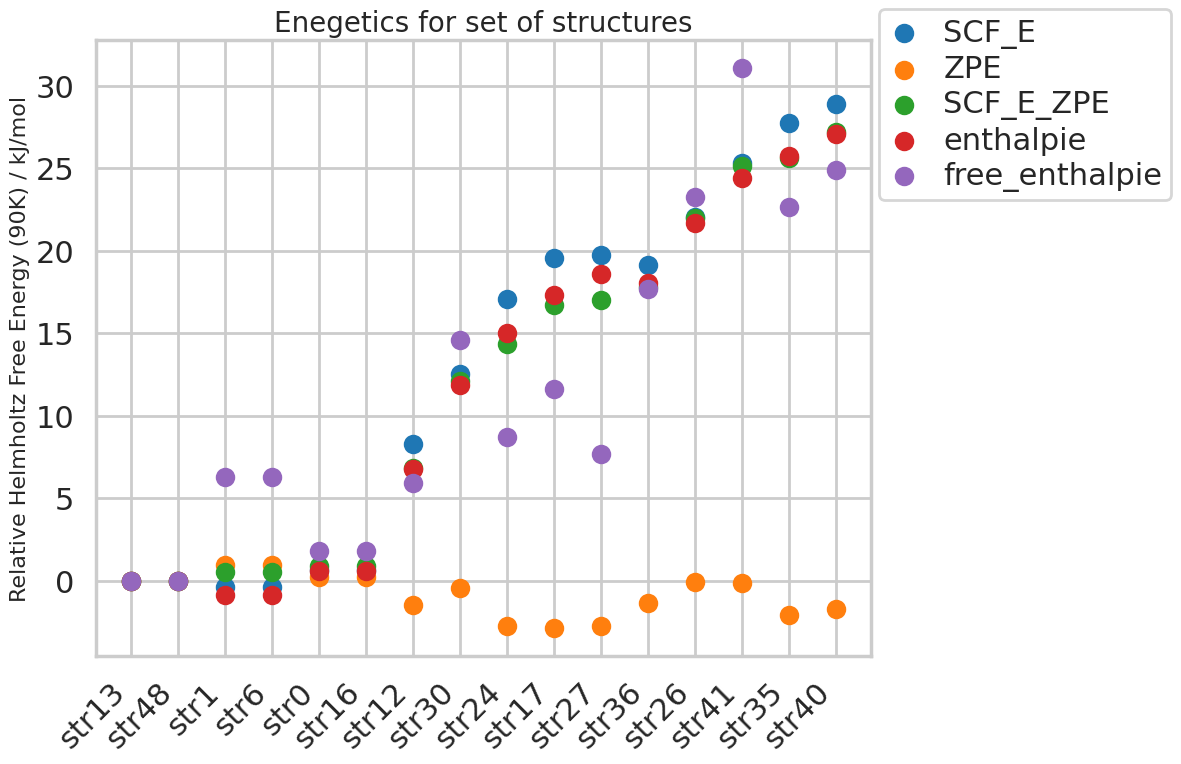

In [196]:
# Get short names as 'strN' from the set
str_num = []
for i in range(len(sorted_energies.index)):
    str_num.append(re.findall(r'str\d+', list(sorted_energies['structures'])[i])[0])

# Plot setting
to_plot = sorted_energies.to_numpy()
sns.set_style(style='whitegrid')
sns.set_context('poster')
plt.figure(figsize=(10,8))
plt.title('Enegetics for set of structures', size=20)
for i in range(1, len(sorted_energies.columns)-1):
    plt.scatter(x = str_num, y = to_plot[:,i], label=sorted_energies.columns[i])

# For just one column
#plt.scatter(x = str_num, y = to_plot[:,column_number], label=sorted_energies.columns[column_number])

plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.ylabel('Relative Helmholtz Free Energy (90K) / kJ/mol', size=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=-1, handlelength=1, borderpad=0.3, labelspacing=0.2)
plt.show()

In [197]:
# Print the data in Thermodynamics_data.datdata:image/png;base64,iVBORwdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA3kAAALMCAYAAABZgHunAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAA9hAAAPYQGoP6dpAABg60lEQVR4nO3deVxV1cL/8a8C6kUcEYdyiERxzimulsPN0B7JNO1ieo0ye7Kbv2ykTM3sWll5Nb3mY956yhE1NcypEWfNVNSu4qyQSTkwCAkq4IHfH7zYD8h4DsOBxef9evVq73PW3mvBWRzP96y916qSkZGRIQAAAACAEao6uwEAAAAAgJJDyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIA4By5vXXX5evr6/69evn7KY45MqVK/rggw80cOBAderUSb6+vvL19dWiRYuc3TTY6caNG5o3b54GDx6szp07W6/lu+++6+ymAQAK4OrsBgAoP/bu3avHH3/crmMef/xxTZ48uZRahIrm6tWrGjFihH755RdnNwXFlJaWptGjR+vQoUPObgoAwE6EPAAoAx999JHmzZsnSTp58qSTW1N6QkJCrID33//937rvvvtUu3ZtSZKXl5cTW1a+BQUFad++ffLz89PSpUud3RxJ0rfffmsFvGHDhunhhx9WvXr1JMn6f2nz9fWVJD333HMaP358mdRZVsrjaw7AHIQ8AHkaOXKk/va3vxVarqw+7FUm77//vt5//31nN8MhP/74oySpQ4cOevXVV53cGhRH1mvp5eWld955Ry4uLk5uEQCgqAh5APLk6emp1q1bO7sZqGAuXbokSbrjjjuc2xAU2+XLlyVJTZs2JeABQAXDxCsAgBKTlpYmSXJzc3NyS1BcqampkngtAaAiqpKRkZHh7EYAKB+yT7xSnHtg+vXrp99++01Dhw7V+++/r8jISH3++ef68ccfdfnyZdWuXVtdunTR008/rc6dOxd6vnPnzikkJER79uzR77//rrS0NHl5eenuu+/WqFGj1LFjxwKPv3nzppYvX67169crMjJSVatWVfPmzTV48GD97W9/0+XLl3X//fdLkt577z0NGzYs33OFhYVp/fr1Onz4sOLi4lS9enU1b95c/fr1U1BQkOrUqZOjfGhoqCZOnFjoz7h582Y1bdpUUubsmmvXrtXtt9+uLVu25HtMUlKSVq1apW3btuns2bNKTExUtWrV1Lx5c3Xr1k0BAQHq1q1bruMiIiK0fPlyHThwQJcuXZLNZlP9+vXl6empu+66S7169VK/fv1UpUqVQtstFW3CnrzuO0pOTlZISIg2b96sqKgoXbt2TfXr11fnzp01dOhQ3Xffffme79b7mX755RctWbJEu3bt0qVLl3Tjxo0cv9Oi+OOPPxQSEqJt27YpMjJS165dU61atVS/fn15e3vr3nvv1YABA9SgQYM8j09JSdHq1av1ww8/6MyZM0pMTFStWrXk6+urBx98UEOHDpWra84LaLJe64IU1g8KEh4eri+++EIHDhxQTEyMqlevrqZNm6pv37564oknVL9+/Rzlo6Ojrb+FkmxPVFSUli1bpr179+q3335TWlqa6tatK09PT7Vr1069e/eWv7+/qlWrJun/3kMKkvX+IuXsg0uWLNHdd9+t0NBQrVu3TmfPnlV8fLwefvhhq/yt71H5KerfYnx8vJYvX65du3bp3Llz+uOPP+Tu7q477rhDd999twYPHqw2bdrkOGdBsteX/TUp7P2poJ8r+3vR5s2b1bBhQy1fvlxff/21zp07p4SEhDzf93/66SetXbtW4eHhio2NlYuLi26//Xb16tVLo0ePVqNGjfJtz6VLl7R06VLt3r1bv/76q27cuKE6derI09NTrVq1Uq9evTRgwAB5eHgU+PsAYD8u1wRQqn744Qe9+uqrun79uvVYXFycwsLCtHXrVs2cOVMBAQH5Hv/ZZ59p9uzZ1ghRlujoaEVHR+urr77Ss88+qxdeeCHP45OSkvTUU0/p559/zvH40aNHdfToUW3atEnTpk0r9OdITEzU888/r59++inH46mpqda5li9frvnz5xcpuBbXjz/+qJdffllXrlzJ8XhaWpqOHz+u48ePa9myZbkmeVm0aJE++OADpaen53j84sWLunjxovVzHDx4UDVr1iy19h87dkzPPPOMdUlglkuXLum7777Td999pwEDBmjmzJmqXr16gecKCwvTq6++qmvXrjncnrNnz2r06NG52nPlyhVduXJFZ8+eVVhYmNLT0/XYY4/lOv7EiRMaN25crmASHx+vPXv2aM+ePfriiy+0YMGCfENiSUpPT9c777yjkJCQHI+npqZa/SMkJET/+te/dO+995ZqW7755hu9+uqruf6GY2JiFBMToxMnTig0NFQbNmwokUvEU1JS9NRTT1n3FJa29evXa+rUqbn63x9//KHDhw/r8OHD+vbbbx0O6qXhypUreu6553T8+PF8y6SkpGjixInatGlTrudOnTqlU6dOaeXKlZo1a1aey72Eh4frmWeeUVJSUo7H4+LiFBcXp1OnTmnTpk2qV69egV/oAHAMIQ9AqTl16pS+/vpreXl5acyYMerQoYMyMjK0a9cuffLJJ0pJSdGUKVPUo0ePXCMKkvS///u/+uc//ykpc5a9kSNH6o477lCtWrUUFRWlkJAQHTp0SPPnz1e9evXyHE166aWXrIDXtWtXBQUFqXnz5oqPj9f69eu1YcMGTZ06tcCfIzU1VU8++aSOHj0qFxcXDRo0SH379lXTpk2Vlpam8PBwLVy4UHFxcRo7dqz1zb8k+fv7q0OHDlq+fLlWrFghSdqwYUOuOgr6NvxWP/30k55++mndvHlTLi4uGjJkiO6//341adJEKSkpOnv2rHbs2KGtW7fmOO7EiRNWwGvatKkee+wxtWnTRnXr1lVycrKioqL0008/2f1htGPHjtbP9NRTT1kjoy+++KJV5k9/+pO1fenSJY0ePVqJiYmqUqWKhg4dqgcffFB169bVmTNntHDhQp04cULff/+9Xn/9dc2ePTvfun///Xe9+uqrqlGjhp599ll1795dLi4uOnLkiNzd3Yv8M7z66qu6fPmy3NzcFBgYqD59+qhBgwbKyMjQxYsX9fPPPyssLCzPY8+dO6fHHntMV69elYeHh0aNGqVOnTqpcePGSkhI0JYtW/TFF1/oyJEjGjdunEJCQqxLIF966SWNGTNGEydOVEREhDp06KD33nsvx/kduVxy5syZVsBr2rSpnn76abVr107Xr1/Xli1bFBISoqtXr+qZZ57RmjVrrFGmRo0aWa9lfm2ypz2xsbGaNGmS0tLS5OnpqVGjRqlz586qV6+ebty4oV9//VX79u3T5s2bcxz32WefKS0tTQ899JCkvCeCunXUPPvPfvLkSfXr10/Dhg3TbbfdptjYWCUnJxe53UX11VdfacKECZKk6tWra/jw4erdu7e8vLx07do1nTx5Ulu2bMmxpEhpveb2mDx5sk6dOqWHH35YAQEBatCggS5cuGDVm5GRoeeff17btm2TJN13330aOHCgmjVrpqpVq+rw4cNauHChfv/9dz3//PNasWJFjisqUlNT9dJLLykpKUk1a9bUyJEj9ec//1menp5KS0tTdHS0Dh06pB9++KFUf06gMiPkAchT1jethfH29s73A8nRo0fVvn17LVmyJMflOJ07d1bz5s316quvKikpSevXr9fo0aNzHHvmzBnNmTNHUualo88991yOywc7dOigBx98UBMmTND69es1e/ZsDRkyJMcHv7CwMO3YsUOSNGDAAP3rX/9S1ar/dytynz591K5dO33wwQcF/oz/8z//o6NHj6p27dpauHChOnTokOP57t2766GHHtKjjz6qmJgYffjhh5o1a5YkqXbt2qpdu7Y8PT2t8sUZrUhJSdGrr76qmzdv6k9/+pP+/e9/689//nOOMl27dlVgYKAuXLiQ4/HvvvtO6enpcnd31xdffJFrRKl79+4KDAzU1atXc4Sywri7u1s/U1ZfqF27dr4/57vvvqvExERJ0ttvv63AwEDruQ4dOiggIED//d//rb179+rrr7/Www8/rL59++Z5rujoaDVs2FBffPGFbrvtNuvxu+66q8jtP3/+vI4ePSop81K6W0fqOnXqpAEDBujVV1/VH3/8kev4CRMm6OrVq2rXrp0+++yzXF9Y9OrVS3/5y1/0zDPP6D//+Y/Wrl2r4cOHS8oMVY0aNbICafbfpaNOnjyphQsXSsrsayEhIdYyFpL05z//Wffee6+eeeYZpaWlacqUKVq9erWkzNcvq/6SaNO2bdusEa5FixblOk/Xrl318MMP68aNGzke9/b2zrFvz0RQJ0+e1LPPPpvjS4bScPnyZb311luSMtuX18/XvXt3jRo1KsffYmm85vY6efKk3nnnnRx/e+3bt7e2V69erW3btsnNzU3z589Xnz59chzfuXNnDRkyRKNGjdLp06c1ffp060ssSTpw4IA1Kj5r1qxcI3WdO3fWoEGDNHHixFyvPYCSwcQrAPK0YsUKPfTQQ4X+lzWbYn6mT5+e5/0WDz30kBo2bCgp87KeW33++edKS0tThw4dcgW8LFWrVtWUKVNUrVo1Xbt2Td99912O51euXClJqlGjhv7xj3/kCHhZnnzyyRwfbm6Vdd+YJL3wwgu5Al6W22+/XePGjZOUGaaKc+lgQb766ivrw9NLL72UK+Bl16RJkxz7sbGxkjJnvizoksFatWrl+bsqCZcuXbJGxHr37p3jQ2aWatWqafr06db9a7decnirV155JUfAs1dMTIy13b1793zLValSJdfoUXh4uLWW3Pvvv5/niLSU+YXCAw88ICnz3qjStGLFCuty3HfeeSdHwMvenkceeUSSrEsKS0NWn6tTp06BQaZGjRqqUaNGidR5xx13lMmaesuWLbMuQ582bVqBP9+tf4vO1qNHjzz/9qTMUbxPP/1UUua9r7cGvCx16tSxlkk5ePBgjtHKrNddku6+++582+Hq6sr9eEApIeQBKDWtW7e2LgO7VZUqVdSuXTtJmSMpt8q61PCBBx4ocAKQ7CNGWR+2pczJVvbv3y8pM0zk9+G7SpUqGjx4cL7n379/v65evWq1pSBZH2bS0tKskaGSlvV7cXd3t0aDiiprMfIzZ86U2of6wuzbt082m02S9Ne//jXfck2bNtU999yT65hbubm5aeDAgcVqU/ZF2gubEONWWZcZent7Wwt35yerf0REROjmzZt2trLo9uzZI0lq1apVgSOa2ftP1jElLet3m5iYmO/lriUtICCgTJZ8yPpbbNasWaGT1ZQ3WZfB5uXMmTP69ddfJRX9PU9Sjvues/9Nffnllw62EkBxcLkmgDwVZ3bNLHfeeWeBz2eNitx6r8xvv/2m+Ph4SZmX+mRd+liY7N8eZ83kJqnAkTpJ+Y7OSZkfyLP06tWrSO2Qco4OlaSsiRLat29v1yWVkvTggw/qk08+UWpqqkaOHKnevXurb9++6tatm1q1alXk2TSL4/Tp09Z2YZdU3nXXXdqxY4euX7+u8+fP57n23h133FHoxCyFadasmbp3767w8HAtWrRIu3bt0oABA+Tn56fOnTsX+HvO6h9RUVGFhrwsaWlpSkxMzHEJb0lJTU21RlQ6depUYNm2bdvKzc1NaWlpRbo02xH9+vVT7dq19ccff+i5556Tn5+f+vXrp+7du6tt27alEsaK+joUR1pamtWXu3XrViZ/OyWpoN9R9ve8Rx99tMjnzP6e161bNzVr1kznz5/X9OnTtWHDBvXv31/du3dXx44drVlUAZQeQh6AUlNYCMm6JPDWmR7j4uIcqi/7vR3Z753KbxSvKM+XRFtKUtZsmtm/KS+qli1batasWZoyZYoSExO1detWazSiXr166t27tx599NECL1ksroSEBGu7sJCT/ZLSrHv4bpXXpYiO+PDDD/XCCy/o0KFDOnPmjM6cOaP58+fLzc1Nd911lwYNGqRhw4blCpRZX0bYK/tssyUp+++psN+vm5ub6tatq5iYmHx/v8VVr149ffzxx3r55Zd16dIl7d27V3v37pUkeXh4qGfPnnrkkUdKdHbF/CZkKUmJiYnKWoHKkb9FZyvod1QS73lubm5asGCBnn/+eZ09e1ZHjhzRkSNHJGVemtu9e3dr0peyGHUFKiNCHoByJ3vo+3//7//pv/7rv4p0nL0jW0WR/TLBtWvX5lrnLD+NGzcu8baUhAceeED33HOPvv76a+3atUvh4eGKj4/XlStXtH79eq1fv15Dhw7V9OnTS+2+vJJUUh8QGzVqpJUrV2rPnj36/vvvtX//fp05c8aaPTU8PFyff/65PvnkkxyTgmT1jzZt2lgzwRa1vtJWXkaXunfvrh9++EHfffedtm/frvDwcF28eFFJSUn64Ycf9MMPP6hXr16aN29eifwNV4R+62wF/Y6yv/8uWLDAmim4MLd+qeDj46MNGzZo69at2rJli8LDw3Xu3DnduHFDu3bt0q5du7Rw4UJ9+umnpTKqDVR2hDwA5U7dunWtbVdXV4dmnss+wlPYaEtBz9erV8/arl+/vtPDW7169XTx4sViXQ5aq1YtPfroo9alWGfPntXmzZu1dOlSXb58WWvXrlXbtm31xBNPlFSzLdlf27i4uAInpMh++W1ZjM5IUs+ePdWzZ09JmaOmWevb/fTTT/r111/10ksv6auvvrLKZ/08165dK/MZEvOS/feU/feXl5s3b1ojq6X9+61evboGDx5s3f96/vx5bd++3VrIfteuXZo9e7YmTZpUqu3IkhWAb72K4Fb5TaBUp04dVa1aVenp6aV2aXaW7IHM0fbaI/vfaK1atYrVr11cXOTv7y9/f39JmTOS7ty5UyEhIdb6om+++ab+53/+p7jNBnALvu4CUO40a9ZMtWrVkpQ5a5sjmjdvbl1aV9gkKNnvQblV27ZtrW1H2yKV3KhK1mQ1ERERJXbJX8uWLTV27FitWrXKmtb9m2++KZFz36pVq1bW9n/+858Cy2ZNDvOnP/1JzZo1K5X2FKRevXoKCAjQ4sWLrcWejx8/nmMWweyTB5X2h/2iqFatmnXvYmGT6xw7dsxaoLysA2qzZs302GOP6csvv7S+OCmtPpeXmjVrSlKeS2Jkl/21zs7Nzc3qy+Hh4dalm6Uhq61Swe1NSEjIcTm0o0rqPS8vDRs21COPPKIvvvjCuld627ZtLKMAlAJCHoByx8XFxVoXbffu3Tp79qzd53B1dbVmftu5c2e+o3UZGRlav359vue55557rEvIlixZ4vCHuewTDaSmpjp0DklW2Lh+/bq++OILh8+TlyZNmlgBIevev5Lm5+dnXWJZ0Kx7v//+u3788cdcxzhL1uielPN3k/V6ZGRkaMmSJQ6fP+sLieL0jSxZbT19+nSBQW/NmjW5jilrHh4e1iLaefW5kvy9ZNe0aVNJmV8A5fc3ffr0aZ08eTLfc2TdRxgdHZ1rMfeiKOrPVqdOHevKhIK+kNq0aVOJhM327dtbwXvVqlVKSUkp9jlv5ebmZr0/37x5s9CwDcB+hDwA5dLYsWPl4uKi9PR0Pf/887p48WK+ZW02m9avX5+rTNbliDdu3NDUqVPzvNRp4cKFBY701a5dW6NGjZKUuUTD9OnTC7xkKjY21lpYOrusNQElWdOTO2Lw4MHW/Vxz5szRvn378i176+8jLCyswA9TFy5cUGRkpKT/+xBc0ho1amRdurVjx448lyxITU3VpEmTrFGmrN9/aTl+/Lg1a2leMjIyrMBZpUqVHPco9erVy5rF8rPPPtPXX39dYF0nT57Uli1bcj2eNXnH+fPni/1BfeTIkdYlflOmTFFSUlKuMrt27bJCXqdOnQqdidNRO3futNZ1zMvVq1etIJpXn8v6vRTnbyYvfn5+kjIvH9y4cWOu55OSkjR58uQCz/HYY49ZI99vvvlmgTOU5vX+Zc9rnjUZ0ubNm/P8XURGRmru3LkFnqOoqlatqmeeecZq22uvvVZgEE1KStKyZctyPJZ1/11+UlNTrSVu3N3dC50cC4D9uCcPQJ7i4uKKNK16jRo11Lx58xKv39fXV6+99pree+89nTlzRoMGDdLw4cPVo0cPNWjQQCkpKfrtt9/0888/69tvv1VMTIw2bNiQ4565AQMGqFevXtq1a5e+//57jRo1SkFBQWrRooXi4+OtiUY6depkfdDM67LKF154Qfv379d//vMfLVmyRPv27dPw4cPVpk0bubu7KzExUWfOnNGPP/6oHTt2qHXr1rkWGu7SpYu1/d577+nvf/+7vLy8rPpuv/32Ik3qUr16dc2YMUNPPfWUrl+/rieffFKDBw+Wv7+/GjdurNTUVEVGRmr79u3asmVLjm/+Fy9erODgYPXt21c9evRQy5YtVatWLSUmJioiIkLLli2zLpsaOXKkHa+WfSZNmqSffvpJiYmJmjRpkg4cOKCAgADVrl1bkZGR+vzzz63QNXDgQGtUt7QcP35cEydOVMeOHXXfffepffv2atCggW7evKno6GiFhoZq9+7dkjJH7rIHdilzmY/AwEAlJCTopZde0vr16xUQEKA77rhDVatWVVxcnI4fP66tW7fq559/1pgxY6wRwCxdu3ZVaGio4uLi9N5772nw4MHWJcuurq5FnvxCyvzbefLJJ/XZZ5/pxIkTGjp0qJ5++mm1bdtW169f19atW7V06VLZbDa5ublp2rRpxfwN5m/Tpk169tlndc899+jee+9V69atVadOHSUnJ+vUqVMKCQnRpUuXJEkjRozIdXyXLl0UHR2tLVu2aOXKleratas1Aubh4eHwhB2DBw/WRx99ZIW5c+fOqXfv3qpSpYoiIiK0aNEiXbx4Ue3atdOxY8fyPIeXl5emTp2qCRMmKC4uToGBgQoMDFSfPn3k5eWl5ORknT59Wlu2bFFUVFSudQLtec3/9re/acuWLbpx44aCgoL03HPPqV27drp27Zr27NmjJUuWqH79+qpatarDM75mN3LkSP3444/64Ycf9O233+rYsWN69NFH1alTJ9WqVUtJSUmKjIzUvn37tGXLFlWrVk2PPfaYdfyePXs0f/58de/eXX379pWvr6/q16+vGzdu6JdfftHKlSutL9f++te/FnlCKwBF59Bflc1m09mzZxUREaGjR48qIiJCJ06csD4cDB06VO+//36JNjTL5s2btW7dOkVERCgmJkYeHh5q0aKF/P39NWLECHl4eJRKvUBls2LFCq1YsaLQcm3atNG6detKpQ2jR4+Wu7u7pk+frqtXr+qzzz7TZ599lmdZNze3PNdLmz17tp566ikdPnxYBw8ezHWPSbt27TR16lQ98sgjkpTnOapVq6bPP/9cEydO1Pfff68TJ04U+ME4r/ehFi1aaODAgfrmm2+smeWy27x5c5FHz3r06KEFCxbolVdeUWJiokJDQxUaGlqkY69fv65vv/1W3377bZ7PV61aVePHj7dG20pD48aNtWjRIj3zzDO6fPmyVq9enefo54ABA/TBBx+UWjtulX2a97x06dJF7777bq7HmzdvrpUrV+r555/XqVOncixNkZfs91hlCQgI0L///W+dP39eixcv1uLFi63nbr/99jxH/woSHBys69eva/ny5fr11181ZcqUXGVq1aqlOXPm5LgHqzSkpaVp+/bt2r59e75lRowYoccffzzX40899ZS+++47paamaurUqTmeK85njfr16+udd97RK6+8opSUFH300Uf66KOPrOdr1KihGTNmaNu2bfmGPEl6+OGHlZGRobfeeks3btzQ0qVLtXTp0lzl8grp9rzmvXv3VlBQkJYuXaqLFy/qjTfeyHGu2267TR9//LGefvppu34P+alSpYpmz56td999VytXrtSvv/5a4OyxeY3Epaena9++fQVebXD//ffrlVdeKZE2A8jJoZD34osv6vvvvy/pthQoOTlZwcHBuf6hi4+PV3x8vA4dOqRly5Zpzpw56ty5c5m2DUDpGT58uPr166eVK1dq9+7dioqK0tWrV1WtWjU1bNhQvr6+uueeezRgwIA8P2jUrl1by5cvV0hIiNavX6+oqChVqVJFzZs3V0BAgJ544gnrEkUp74CW9fhHH32k8PBwffXVVwoPD9fly5eVkpIiDw8PNWvWTJ06dVLfvn3zXTT9n//8pzp06KDvvvtOUVFRSk5OLnS2vPz07t1bYWFhWrFihbZu3Wr9Xv70pz+pRYsW6t69uwYNGpTjmFmzZmnbtm3au3evzp49q9jYWF25ckXVqlXT7bffru7du2vEiBFq06aNQ22yR7t27fTtt98qJCREYWFhioqK0vXr11WvXj117txZQ4cOzTXaVVoGDRokT09P/fjjjzpy5IguXbqkuLg43bx5U56enmrXrp0CAgL04IMP5jv1vLe3t7766it98803+v7773XkyBHFx8fLZrOpbt268vb2Vrdu3dS/f39rwonsatasqZUrV+rf//63du/erd9//71YE+tUrVpVU6dO1YMPPqiVK1fqwIEDio2NVbVq1dSsWTP17dtXTzzxRKlfJjdx4kTdc889+umnn3Ty5EnFxMQoPj5eLi4uaty4sbp06aK//vWv+a7N2LZtW33xxRf67LPPdPDgQcXGxpbY/XkDBw7U7bffrk8++UQHDhzQ1atX1aBBA/Xo0UNPPfWUWrVqpW3bthV6nqFDh+ree+9VSEiIdu7cqfPnzys5OVkeHh7y9vZWjx49rFlFs7P3NX/jjTfUuXNnrVy5UsePH9fNmzfVpEkT9e/fX2PGjMkxE3BJcHNz01tvvaWRI0dq9erV2rt3ry5cuKBr167J3d1dTZs2Vfv27dWnT59c6xyOGTNGvr6++vHHH3X8+HFdvnzZWn+vQYMG6tSpkx5++GH95S9/KdE2A/g/VTIcuPh/3LhxOW4yrlu3rurWrWvNQlXSI3k2m03PPPOMdu7cKSnzDSIwMFA+Pj5KTEzUxo0brW/n69SpoxUrVqhly5YlVj8As61bt06vvfaaJOmHH34olctPAQAAyopDI3mdOnVSy5Yt1b59e7Vv317NmjVTaGioJk6cWNLtkyStXr3aCng+Pj5avHixGjRoYD0/atQoffDBB/r888+VmJioN998UyEhIaXSFgDm2bRpk6TMS46cMVU/AABASXIo5P39738v6Xbky2azad68edb+jBkzcgS8LMHBwdqzZ4+OHz+u8PBw7dq1K99LpgBUHpcuXVKdOnVUo0aNPJ9fvXq1da/Qww8/XGLr2QEAADhLuZ/OaP/+/dYCs35+fnneyyBlrqsVFBSkSZMmScr8Zp6QB2D37t365z//qQcffFB+fn667bbblJ6ervPnz+vrr7+2Zrxr0KCBxo4d6+TWAgAAFF+5D3k7duywtvv06VNg2ezPZz8OQOUWHx+f76x3UuZU6J988kmJT1wAAADgDOU+5GVfp6tjx44FlvXy8lKTJk104cIFxcbGKj4+vtRmDktNTVVCQoK1X716dbm4uJRKXQAcd/fdd2vixInas2ePoqKidOXKFSUnJ6tWrVry9vZWnz599Mgjj6hmzZp5LhoNAABQGJvNppSUFGu/bt26qlatmtPaU+5DXlRUlLVdlDWkmjZtqgsXLkiSIiMjSy3kJSQk6Pz586VybgAlq2PHjgV+SRQdHV2GrQEAAJVBw4YNnVZ33gv+lCNXr161totyKVXdunXzPBYAAAAAKoNyH/KuXbtmbVevXr3Q8tnLJCcnl0qbAAAAAKC8KveXa5ZXtwbOZs2ayd3d3UmtgenOnDkjm80mFxcX+fj4OLs5MBh9DWWFvoayQl9DWbh27VqOW7mKMjhVmsp9yHN3d1diYqIkKSUlRa6uBTc5+w2PNWvWLLV23TrJiru7uzw8PEqtPlRuVatWlc1mU9WqVelnKFX0NZQV+hrKCn0NzuDsCRnL/eWatWrVsravXLlSaPnsM15mPxYAAAAAKoNyH/K8vb2t7aLMgJe9zJ133lkqbQIAAACA8qrch7zWrVtb20eOHCmwbGxsrLV8gqenZ6ktnwAAAAAA5VW5D3m9e/e2tnfs2FFg2e3bt1vbffv2LbU2AQAAAEB5Ve5Dnp+fn7y8vCRJ+/bt09GjR/MsZ7PZtHTpUms/ICCgTNoHAAAAAOWJU0NeaGiofH195evrq6CgoDzLuLi4aNy4cdb+hAkTFBcXl6vczJkzdfz4cUlS165dc4wAAgAAAEBl4dASCufPn9eaNWtyPHby5Elr+9ixY5o9e3aO53v06KGePXs6Up2GDx+usLAw7d69W6dPn9aQIUMUGBgoHx8fJSQkaNOmTTpw4IAkqXbt2po2bZpD9QAAAABARedQyPv999+1YMGCfJ8/efJkjtAnSa6urg6HPFdXV82dO1fBwcHaunWrYmJiNH/+/FzlGjdurNmzZ6tVq1YO1QMAAAAAFV25Xww9i4eHhxYsWKCwsDCtW7dOR44cUVxcnGrWrKnmzZurf//+GjFiBGvjAQAAAKjUHAp5f/7zn3ON1Dli2LBhGjZsmF3H+Pv7y9/fv9h1AwAAAICJyv3smgAAAACAoiPkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYxLW4J9i8ebPWrVuniIgIxcTEyMPDQy1atJC/v79GjBghDw+PkminJTo6WmvWrNHevXsVGRmppKQkVatWTfXr11fbtm3Vv39/BQQEyM3NrUTrBQAAAICKwOGQl5ycrODgYG3ZsiXH4/Hx8YqPj9ehQ4e0bNkyzZkzR507dy5uOyVJCxcu1IcffqjU1NQcj9+8eVPXrl1TdHS0fvjhB3388ceaO3euWrduXSL1AgAAAEBF4VDIs9lseuGFF7Rz505JUoMGDRQYGCgfHx8lJiZq48aNOnjwoC5cuKCxY8dqxYoVatmyZbEaumzZMr3//vvWfpcuXdSvXz81adJESUlJOnPmjEJDQ3Xt2jVFRUXp8ccf14YNG+Tl5VWsegEAAACgInEo5K1evdoKeD4+Plq8eLEaNGhgPT9q1Ch98MEH+vzzz5WYmKg333xTISEhDjfyxo0b+vDDD639d955R4GBgbnK/b//9//0xBNP6NSpU7py5Yr+93//VxMnTnS4XgAAAACoaOyeeMVms2nevHnW/owZM3IEvCzBwcFq27atJCk8PFy7du1yuJEHDx5UcnKyJKljx455BjxJql+/vl555RVrf//+/Q7XCQAAAAAVkd0hb//+/YqJiZEk+fn5qX379nmWc3FxUVBQkLW/adMmB5soxcXFWdstWrQosGz2569du+ZwnQAAAABQEdkd8nbs2GFt9+nTp8Cy2Z/Pfpy9PD09re1ffvmlwLLZn2/VqpXDdQIAAABARWR3yDt16pS13bFjxwLLenl5qUmTJpKk2NhYxcfH21udJKlbt26qV6+eJCkiIkKrV6/Os1x8fLx1717VqlU1evRoh+oDAAAAgIrK7olXoqKirO2mTZsWWr5p06a6cOGCJCkyMlL169e3t0pVr15d//jHP/Tyyy/r5s2beuONNxQaGppjds3Tp09r7dq1Sk5Olru7u959911169bN7roAAAAAoCKzO+RdvXrV2s4aXStI3bp18zzWXg888IAWLlyoadOm6fTp0zp48KAOHjyYo4ybm5v+/ve/a8SIEdYIYlk5c+aMqla1e2AUKJK0tDTr/4cPH3Zya2Ay+hrKCn0NZYW+hrKQnp7u7CbkYHfIyz6ZSfXq1Qstn71M1gyZjrr77rs1ZcoUvf/++zp27Fiu59PS0rR8+XJdv35dL7/8smrUqFGs+uxhs9lks9nKrD5UXln/WAGljb6GskJfQ1mhr6GycGidPGeIj4/Xiy++qL1796pOnTqaOHGi7r//fjVu3Fg3btxQRESEFi5cqO3bt2vx4sU6dOiQPvnkkyKNNpYEFxcXRvJQarL/o+Tm5ubElsB09DWUFfoaygp9DWUhPT29XA342B3y3N3dlZiYKElKSUmRq2vBp0hJSbG2a9asaW91kqTr169r1KhRioyMVJ06dbRq1Srdcccd1vNubm7q2bOnevbsqWnTpikkJESHDx/WO++8o1mzZjlUp718fHzk4eFRJnWh8jl8+LDS0tLk5uamTp06Obs5MBh9DWWFvoayQl9DWUhKStLJkyed3QyL3UNPtWrVsravXLlSaPmEhIQ8j7XH8uXLFRkZKUkaM2ZMjoB3q+DgYNWuXVuS9PXXX1tr+gEAAABAZWB3yPP29ra2o6OjCy2fvcydd95pb3WSpG3btlnb9957b4Fl3d3d1aVLF0mZw6ZHjhxxqE4AAAAAqIjsDnmtW7e2tgsLULGxsdbyCZ6eng4tnyBJly9ftraLMhqYvUz2iWIAAAAAwHR2h7zevXtb2zt27Ciw7Pbt263tvn372luVJfu9fFmhsSC///67tZ19CQcAAAAAMJ3dIc/Pz09eXl6SpH379uno0aN5lrPZbFq6dKm1HxAQ4GATc44ebtiwocCy586ds9ZAqVq1qjp06OBwvQAAAABQ0dgd8lxcXDRu3Dhrf8KECYqLi8tVbubMmTp+/LgkqWvXrjlGALMLDQ2Vr6+vfH19FRQUlGeZQYMG5Si/evXqPMvFxMToxRdf1M2bNyVJf/nLXxjJAwAAAFCpOLRO3vDhwxUWFqbdu3fr9OnTGjJkiAIDA+Xj46OEhARt2rRJBw4ckCTVrl1b06ZNK1Yje/XqpQceeEDfffedMjIy9MYbb2j9+vW6//771ahRI6WkpCgiIkLr1q3TH3/8ISnzMs3XX3+9WPUCAAAAQEXjUMhzdXXV3LlzFRwcrK1btyomJkbz58/PVa5x48aaPXu2WrVqVeyGzpw5Ux4eHvryyy8lZV4qum/fvjzLent7a/bs2WrRokWx6wUAAACAisShkCdJHh4eWrBggcLCwrRu3TodOXJEcXFxqlmzppo3b67+/ftrxIgRDq+Nd6tq1app+vTpCgoKUmhoqA4ePKjo6GglJSXJzc1N9evXV4cOHXT//fdr4MCBqlatWonUCwAAAAAVicMhL4u/v7/8/f0dPn7YsGEaNmxYkcu3bdtWkydPdrg+AAAAADCZ3ROvAAAAAADKL0IeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBXIt7gs2bN2vdunWKiIhQTEyMPDw81KJFC/n7+2vEiBHy8PAoiXbmcuzYMW3YsEF79uzRxYsXlZSUpHr16snLy0udO3eWn5+f+vfvLxcXl1KpHwAAAADKI4dDXnJysoKDg7Vly5Ycj8fHxys+Pl6HDh3SsmXLNGfOHHXu3Lm47bQkJSXp3Xff1dq1a5WRkZHjucuXL+vy5cs6evSoQkJCtH//ftWuXbvE6gYAAACA8s6hkGez2fTCCy9o586dkqQGDRooMDBQPj4+SkxM1MaNG3Xw4EFduHBBY8eO1YoVK9SyZctiNzYhIUFPPfWUIiIiJEmNGjXSgAED5Ovrq1q1aik5OVnnzp3T7t27dfTo0WLXBwAAAAAVjUMhb/Xq1VbA8/Hx0eLFi9WgQQPr+VGjRumDDz7Q559/rsTERL355psKCQkpdmNfeeUVK+CNGTNGL774oqpXr56r3Msvv6xLly7J3d292HUCAAAAQEVi98QrNptN8+bNs/ZnzJiRI+BlCQ4OVtu2bSVJ4eHh2rVrVzGaKYWGhlrnGDlypCZMmJBnwMvSqFEjuboW+5ZDAAAAAKhQ7A55+/fvV0xMjCTJz89P7du3z7Oci4uLgoKCrP1NmzY52MRMn376qSTJ3d1dwcHBxToXAAAAAJjK7pC3Y8cOa7tPnz4Fls3+fPbj7HXgwAFFRkZKku6///5Sm7ETAAAAACo6u69nPHXqlLXdsWPHAst6eXmpSZMmunDhgmJjYxUfH6/69evb3cj9+/db23fddZck6fvvv9fq1at17NgxJSYmqm7dumrXrp0eeOABDRkyhEs1AQAAAFRKdiehqKgoa7tp06aFlm/atKkuXLggSYqMjHQo5GVNtiJJnp6eGj9+vL7//vscZWJiYrR9+3Zt375dixYt0vz589WsWTO76wIAAACAiszukHf16lVru169eoWWr1u3bp7H2iPrHkBJmjt3rqKiouTm5qaHH35Y3bp1k6urq06cOKE1a9YoISFBp06d0hNPPKHQ0NAc9ZemM2fOqGpVu69+BYokLS3N+v/hw4ed3BqYjL6GskJfQ1mhr6EspKenO7sJOdgd8q5du2ZtFzS7ZV5lkpOT7a1OkpSYmGhtR0VFqU6dOlq0aJHatWtnPf7QQw9p9OjRGj16tM6cOaPffvtNH374oaZNm+ZQnfay2Wyy2WxlUhcqt6x/rIDSRl9DWaGvoazQ11BZVIgb1zIyMnLsv/baazkCXhYvLy/NmjVLQ4YMkSStXbtWr732WplM1OLi4sJIHkpN9n+U3NzcnNgSmI6+hrJCX0NZoa+hLKSnp5erAR+7Q567u7s1spaSklLoBCcpKSnWds2aNe2tLtdx7u7uGjx4cL5l27Rpo86dO+vnn39WamqqDhw4oL59+zpUrz18fHyY9ROl5vDhw0pLS5Obm5s6derk7ObAYPQ1lBX6GsoKfQ1lISkpSSdPnnR2Myx2Dz3VqlXL2r5y5Uqh5RMSEvI81h61a9e2tlu3bq1q1aoVWL5Dhw7W9vnz5x2qEwAAAAAqIrtDnre3t7UdHR1daPnsZe688057q8t1XFFGy7KXSUpKcqhOAAAAAKiI7A55rVu3traPHDlSYNnY2Fhr+QRPT0+Hlk+QMi/BzFKU0Ja9jKOjhwAAAABQEdkd8nr37m1t79ixo8Cy27dvt7aLc19cnz59VKVKFUmZi7GnpqYWWD77unrZRx4BAAAAwHR2hzw/Pz95eXlJkvbt26ejR4/mWc5ms2np0qXWfkBAgINNlBo3bqy7775bUuYSDuvXr8+37IkTJ/Tzzz9LypywpWvXrg7XCwAAAAAVjd0hz8XFRePGjbP2J0yYoLi4uFzlZs6cqePHj0uSunbtmmMEMLvQ0FD5+vrK19dXQUFB+db78ssvW9szZszQsWPHcpWJjY1VcHCwtR8UFKQaNWoU/kMBAAAAgCEcWidv+PDhCgsL0+7du3X69GkNGTJEgYGB8vHxUUJCgjZt2qQDBw5IypwZsyQWJO/SpYuefvppffrpp0pMTNTw4cM1dOhQdevWTa6urjp+/LjWrFljzebZoUOHHGEUAAAAACoDh0Keq6ur5s6dq+DgYG3dulUxMTGaP39+rnKNGzfW7Nmz1apVq2I3VJKCg4Pl4uKiTz/9VGlpaVq1apVWrVqVq1yvXr304Ycfqnr16iVSLwAAAABUFA6FPClzmYIFCxYoLCxM69at05EjRxQXF6eaNWuqefPm6t+/v0aMGFHis1u+9NJLGjhwoNasWaPdu3fr0qVLunnzpjw9PdWlSxcNGTKkTBY/BwAAAIDyyOGQl8Xf31/+/v4OHz9s2DANGzbMrmPatGmjN954w+E6AQAAAMBUdk+8AgAAAAAovwh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGcS3uCTZv3qx169YpIiJCMTEx8vDwUIsWLeTv768RI0bIw8OjJNpZoNdff11r16619p977jmNHz++1OsFAAAAgPLG4ZCXnJys4OBgbdmyJcfj8fHxio+P16FDh7Rs2TLNmTNHnTt3Lm4787V9+/YcAQ8AAAAAKjOHQp7NZtMLL7ygnTt3SpIaNGigwMBA+fj4KDExURs3btTBgwd14cIFjR07VitWrFDLli1LtOGSlJSUpKlTp0qS3N3dde3atRKvAwAAAAAqEofuyVu9erUV8Hx8fLRu3Tq9+OKLGjRokEaNGqUVK1ZozJgxkqTExES9+eabJdfibGbMmKELFy6oSZMmevTRR0ulDgAAAACoSOwOeTabTfPmzbP2Z8yYoQYNGuQqFxwcrLZt20qSwsPDtWvXrmI0M7c9e/Zo1apVkqSpU6eqZs2aJXp+AAAAAKiI7A55+/fvV0xMjCTJz89P7du3z7Oci4uLgoKCrP1NmzY52MTcrl+/rilTpigjI0MBAQG67777SuzcAAAAAFCR2R3yduzYYW336dOnwLLZn89+XHHNmjVL58+fV926dTV58uQSOy8AAAAAVHR2h7xTp05Z2x07diywrJeXl5o0aSJJio2NVXx8vL3V5XLw4EGFhIRIkl577bU8LxUFAAAAgMrK7pAXFRVlbTdt2rTQ8tnLREZG2ltdDikpKZo0aZLS09PVs2dPPfLII8U6HwAAAACYxu4lFK5evWpt16tXr9DydevWzfNYR/zrX/9SVFSUatSooWnTphXrXCXtzJkzqlrVoclKgUKlpaVZ/z98+LCTWwOT0ddQVuhrKCv0NZSF9PR0ZzchB7tDXva16KpXr15o+exlkpOT7a3OcvjwYS1atEiSNH78eDVv3tzhc5UGm80mm83m7GagEsj6xwoobfQ1lBX6GsoKfQ2VhUOLoZe11NRUTZ48WTabTe3bt9eTTz7p7Cbl4uLiwkgeSk32f5Tc3Nyc2BKYjr6GskJfQ1mhr6EspKenl6sBH7tDnru7uxITEyVl3iPn6lrwKVJSUqxtR9ey+/jjj3Xq1Cm5uLjo7bfflouLi0PnKU0+Pj7y8PBwdjNgqMOHDystLU1ubm7q1KmTs5sDg9HXUFboaygr9DWUhaSkJJ08edLZzbDYPfRUq1Yta/vKlSuFlk9ISMjz2KI6ceKEPv30U0nS6NGj812XDwAAAADgwEiet7e3oqOjJUnR0dGFzrCZVVaS7rzzTnurU2hoqNLS0lS1alW5ublp/vz5eZbbv39/ju2sct7e3ho4cKDd9QIAAABARWR3yGvdurV27twpSTpy5Ih69OiRb9nY2FhduHBBkuTp6an69evb3cCMjAxJmde5LliwoEjH7N27V3v37pUk3X///YQ8AAAAAJWG3Zdr9u7d29resWNHgWW3b99ubfft29feqgAAAAAAdrJ7JM/Pz09eXl6KiYnRvn37dPTo0Tzvk7PZbFq6dKm1HxAQ4FADJ0+erMmTJxda7qOPPtK8efMkSc8995zGjx/vUH0AAAAAUJHZPZLn4uKicePGWfsTJkxQXFxcrnIzZ87U8ePHJUldu3bNMQKYXWhoqHx9feXr66ugoCB7mwMAAAAAyMahdfKGDx+usLAw7d69W6dPn9aQIUMUGBgoHx8fJSQkaNOmTTpw4IAkqXbt2po2bVqJNhoAAAAAkDeHQp6rq6vmzp2r4OBgbd26VTExMXnOetm4cWPNnj1brVq1KnZDAQAAAACFcyjkSZKHh4cWLFigsLAwrVu3TkeOHFFcXJxq1qyp5s2bq3///hoxYoRDa+MBAAAAABzjcMjL4u/vL39/f4ePHzZsmIYNG1bcZmj8+PFMtgIAAACg0rN74hUAAAAAQPlFyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAM4lrcE2zevFnr1q1TRESEYmJi5OHhoRYtWsjf318jRoyQh4dHSbRTSUlJ2r17t/bu3atjx47pl19+0dWrV1W9enU1bNhQnTp10qBBg9S7d29VqVKlROoEAAAAgIrG4ZCXnJys4OBgbdmyJcfj8fHxio+P16FDh7Rs2TLNmTNHnTt3LlYjFy5cqNmzZyslJSXXczdv3lRUVJSioqK0bt06de/eXf/85z912223FatOAAAAAKiIHAp5NptNL7zwgnbu3ClJatCggQIDA+Xj46PExERt3LhRBw8e1IULFzR27FitWLFCLVu2dLiRUVFRVsBr1KiR7rnnHrVv316enp5KSUnRzz//rPXr1+vatWsKDw9XUFCQVq1aJU9PT4frBAAAAICKyKGQt3r1aivg+fj4aPHixWrQoIH1/KhRo/TBBx/o888/V2Jiot58802FhIQ43MgqVaqoV69eGjNmjHr27KmqVXPeSjh06FCNHTtWTz31lKKiohQdHa2ZM2fqvffec7hOAAAAAKiI7J54xWazad68edb+jBkzcgS8LMHBwWrbtq0kKTw8XLt27XK4kS+99JI+++wz3XvvvbkCXpbbb79dc+bMsfa/+eYbXb9+3eE6AQAAAKAisjvk7d+/XzExMZIkPz8/tW/fPs9yLi4uCgoKsvY3bdrkYBOlunXrFqlcmzZt5O3tLUm6fv26zp0753CdAAAAAFAR2R3yduzYYW336dOnwLLZn89+XGnKPptnXhO1AAAAAIDJ7A55p06dsrY7duxYYFkvLy81adJEkhQbG6v4+Hh7q7NLamqqfvnlF2ufGTYBAAAAVDZ2T7wSFRVlbTdt2rTQ8k2bNtWFCxckSZGRkapfv769VRbZxo0bdfXqVUlS+/bt5eXlVWp13erMmTP53i8IFFdaWpr1/8OHDzu5NTAZfQ1lhb6GskJfQ1lIT093dhNysDvkZYUoSapXr16h5bPfT5f92JIWHx+vmTNnWvvPPvtsqdWVF5vNJpvNVqZ1onLK+scKKG30NZQV+hrKCn0NlYXdIe/atWvWdvXq1Qstn71McnKyvdUVSWpqqsaPH6+4uDhJkr+/v/r3718qdeXHxcWFkTyUmuz/KLm5uTmxJTAdfQ1lhb6GskJfQ1lIT08vVwM+Dq2TV56kp6dr0qRJCg8PlyQ1b95c06dPL/N2+Pj45Jj0BShJhw8fVlpamtzc3NSpUydnNwcGo6+hrNDXUFboaygLSUlJOnnypLObYbF76Mnd3d3aLsrsldnL1KxZ097qCpSRkaGpU6dqw4YNkjInWlm4cKHq1KlTovUAAAAAQEVhd8irVauWtX3lypVCyyckJOR5bHFlZGTorbfe0qpVqyRJjRs31uLFi4s0GQwAAAAAmMrukJe12LgkRUdHF1o+e5k777zT3urylJGRoX/84x9auXKlJKlRo0ZasmSJmjdvXiLnBwAAAICKyu6Q17p1a2v7yJEjBZaNjY21lk/w9PQskeUTsgLeihUrJEkNGzbUkiVL1KJFi2KfGwAAAAAqOrtDXu/eva3tHTt2FFh2+/bt1nbfvn3trSqXWwOel5eXlixZojvuuKPY5wYAAAAAE9gd8vz8/KxFxvft26ejR4/mWc5ms2np0qXWfkBAgINN/D/Tpk3LFfCyXz4KAAAAAJWd3SHPxcVF48aNs/YnTJhgrU+X3cyZM3X8+HFJUteuXXOMAGYXGhoqX19f+fr6KigoKN963377bS1fvlzS/wW8krrHDwAAAABM4dA6ecOHD1dYWJh2796t06dPa8iQIQoMDJSPj48SEhK0adMmHThwQJJUu3ZtTZs2rViNnD17tpYtWyZJqlKlih5//HFFRkYqMjKywOPatWun2267rVh1AwAAAEBF4lDIc3V11dy5cxUcHKytW7cqJiZG8+fPz1WucePGmj17tlq1alWsRh48eNDazsjI0KxZs4p03Hvvvadhw4YVq24AAAAAqEgcCnmS5OHhoQULFigsLEzr1q3TkSNHFBcXp5o1a6p58+bq37+/RowYUaJr4wEAAAAACuZwyMvi7+8vf39/h48fNmxYoaNt2SdwAQAAAADkz+6JVwAAAAAA5RchDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIK7FPcHmzZu1bt06RUREKCYmRh4eHmrRooX8/f01YsQIeXh4lEQ7nV4nAAAAAFQEDoe85ORkBQcHa8uWLTkej4+PV3x8vA4dOqRly5Zpzpw56ty5c3Hb6bQ6AQAAAKAicSjk2Ww2vfDCC9q5c6ckqUGDBgoMDJSPj48SExO1ceNGHTx4UBcuXNDYsWO1YsUKtWzZslgNdUadAAAAAFDROBTyVq9ebYUtHx8fLV68WA0aNLCeHzVqlD744AN9/vnnSkxM1JtvvqmQkJBiNdQZdQIAAABARWP3xCs2m03z5s2z9mfMmJEjbGUJDg5W27ZtJUnh4eHatWuXw410Rp0AAAAAUBHZHfL279+vmJgYSZKfn5/at2+fZzkXFxcFBQVZ+5s2bXKwic6pEwAAAAAqIrtD3o4dO6ztPn36FFg2+/PZj6sIdQIAAABARWT3PXmnTp2ytjt27FhgWS8vLzVp0kQXLlxQbGys4uPjVb9+fbsb6Yw6C2Oz2XLsX7t2rcTrALKkp6db/09KSnJya2Ay+hrKCn0NZYW+hrJwaxa4NSuUNbtDXlRUlLXdtGnTQss3bdpUFy5ckCRFRkY6FLicUWdhUlJScuyfP3++xOsAbmWz2XTy5ElnNwOVAH0NZYW+hrJCX0NZujUrlDW7L9e8evWqtV2vXr1Cy9etWzfPY8t7nQAAAABQEdkd8rIPRVavXr3Q8tnLJCcn21ud0+oEAAAAgIrIoXXykHO0UMoMli4uLs5pDAAAAACnsdlsOS7RvDUrlDW7Q567u7sSExMlZV5r6upa8Cmy/7A1a9a0tzqn1VmYatWqqWHDhqVybgAAAABwlN2Xa9aqVcvavnLlSqHlExIS8jy2vNcJAAAAABWR3SHP29vb2o6Oji60fPYyd955p73VOa1OAAAAAKiI7A55rVu3traPHDlSYNnY2FhrKQNPT0+HlzJwRp0AAAAAUBHZHfJ69+5tbe/YsaPAstu3b7e2+/bta29VTq0TAAAAACoiu0Oen5+fvLy8JEn79u3T0aNH8yxns9m0dOlSaz8gIMDBJjqnTgAAAACoiOwOeS4uLho3bpy1P2HCBMXFxeUqN3PmTB0/flyS1LVr1xyjcdmFhobK19dXvr6+CgoKKpM6AQAAAMBUDq2TN3z4cIWFhWn37t06ffq0hgwZosDAQPn4+CghIUGbNm3SgQMHJEm1a9fWtGnTit1QZ9QJAAAAABVNlYyMjAxHDkxKSlJwcLC2bt2ab5nGjRtr9uzZ6tq1a75lQkNDNXHiREmZl2Vmv9yytOoEAAAAAFM5NJInSR4eHlqwYIHCwsK0bt06HTlyRHFxcapZs6aaN2+u/v37a8SIESW6Tp0z6gQAAACAisThkTwAAAAAQPlj98QrAAAAAIDyi5AHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABnF1dgOcZfPmzVq3bp0iIiIUExMjDw8PtWjRQv7+/hoxYoQ8PDyMqBPOV1ave1JSknbv3q29e/fq2LFj+uWXX3T16lVVr15dDRs2VKdOnTRo0CD17t1bVapUKZE6Ub6Uh/eY119/XWvXrrX2n3vuOY0fP77U60XZclZfO3bsmDZs2KA9e/bo4sWLSkpKUr169eTl5aXOnTvLz89P/fv3l4uLS6nUj7JX1n0tOjpaa9as0d69exUZGamkpCRVq1ZN9evXV9u2bdW/f38FBATIzc2tROuFc9hsNp09e1YRERE6evSoIiIidOLECd24cUOSNHToUL3//vulUndp9+0qGRkZGSXU1gohOTlZwcHB2rJlS75lmjRpojlz5qhz584Vtk44X1m+7gsXLtTs2bOVkpJSaNnu3bvrn//8p2677bZi1Ynyo7y8x2zfvl1jx47N8RghzyzO6mtJSUl69913tXbtWhX2sWX//v2qXbt2idUN53BGX1u4cKE+/PBDpaamFljO29tbc+fOVevWrUukXjjP+PHj9f333+f7fGmEvLLq25Uq5NlsNj3zzDPauXOnJKlBgwYKDAyUj4+PEhMTtXHjRh08eFCSVKdOHa1YsUItW7ascHXC+cr6dX/zzTf1xRdfSJIaNWqke+65R+3bt5enp6dSUlL0888/a/369bp27ZokqWnTplq1apU8PT2L+ZPC2crLe0xSUpIGDRqkCxcuyN3d3eprhDxzOKuvJSQk6KmnnlJERISkzPe4AQMGyNfXV7Vq1VJycrLOnTun3bt36+jRo9q3bx8hr4JzRl9btmyZ3n77bWu/S5cu6tevn5o0aaKkpCSdOXNGoaGh1ntbvXr1tGHDBnl5eRWrXjjXuHHjtHnzZmu/bt26qlu3rn755RdJJR/yyrRvZ1QiK1asyGjdunVG69atMwICAjJiYmJylXn//fetMn/7298qZJ1wvrJ+3d98882MMWPGZOzatSvDZrPlWSY6OjrjgQcesOp8/fXXi1Unyofy8h4zZcqUjNatW2f07ds347333rPqmzt3bqnUh7LnrL42ZswY65zvv/9+xo0bN/Ite/HixYy0tLQSqRfOU9Z97fr16xldunSxzrdq1ao8y8XFxWUMGjTIKjd9+vRi1Qvn+/jjjzNmzpyZ8c0332T8+uuvGRkZGRlffvml9RpPmDChROsry75daSZesdlsmjdvnrU/Y8YMNWjQIFe54OBgtW3bVpIUHh6uXbt2Vag64XzOeN1feuklffbZZ7r33ntVtWref9a333675syZY+1/8803un79usN1wvnKy3vMnj17tGrVKknS1KlTVbNmzRI9P5zPWX0tNDTUOsfIkSM1YcIEVa9ePd/yjRo1kqtrpZ1uwAjO6GsHDx5UcnKyJKljx44KDAzMs1z9+vX1yiuvWPv79+93uE6UD3//+9/1yiuv6L/+67/UrFmzUq2rrPt2pQl5+/fvV0xMjCTJz89P7du3z7Oci4uLgoKCrP1NmzZVqDrhfM543evWrVukcm3atJG3t7ck6fr16zp37pzDdcL5ysN7zPXr1zVlyhRlZGQoICBA9913X4mdG+WHs/rap59+Kklyd3dXcHBwsc6FisEZfS0uLs7abtGiRYFlsz+fdekmUBRl3bcrTcjbsWOHtd2nT58Cy2Z/PvtxFaFOOF95f92zz9ZUlIlaUH6Vh742a9YsnT9/XnXr1tXkyZNL7LwoX5zR1w4cOKDIyEhJ0v33388M1JWEM/pa9vvTs+7Fyk/251u1auVwnah8yrpvV5qQd+rUKWu7Y8eOBZb18vJSkyZNJEmxsbGKj4+vMHXC+crz656amprjHyhm2KzYnN3XDh48qJCQEEnSa6+9ludlJzCDM/pa9kvh7rrrLknS999/r6efflr33nuvOnTooF69emns2LH68ssvdfPmTYfqQfnijL7WrVs31atXT5IUERGh1atX51kuPj5eH374oSSpatWqGj16tEP1oXIq675daUJeVFSUtd20adNCy2cvk/VNYkWoE85Xnl/3jRs36urVq5Kk9u3bMytYBefMvpaSkqJJkyYpPT1dPXv21COPPFKs86F8c0Zfy5pNU8ocaRk/frzGjx+vHTt2KDY2VmlpaYqJidH27ds1adIkDR06VOfPn3eoLpQfzuhr1atX1z/+8Q/rfs433nhDI0eO1KeffqqNGzdq5cqVevvtt+Xv769Tp07J3d1ds2bNUrdu3RyqD5VTWfftSnN3ctYHW0nWtzUFyX6PU/Zjy3udcL7y+rrHx8dr5syZ1v6zzz5banWhbDizr/3rX/9SVFSUatSooWnTphXrXCj/nNHXsu5dkaS5c+cqKipKbm5uevjhh9WtWze5urrqxIkTWrNmjRISEnTq1Ck98cQTCg0NLfJ9yih/nPW+9sADD2jhwoWaNm2aTp8+rYMHD1pT2Wdxc3PT3//+d40YMcIaZQGKqqz7dqUZyct+c2xBM3PlVSZrxqWKUCecrzy+7qmpqRo/frx1c7m/v7/69+9fKnWh7Dirrx0+fFiLFi2SlLmQbPPmzR0+FyoGZ/S1xMREazsqKkp16tTRqlWr9M4772jo0KF66KGH9Oqrr2rjxo3y8fGRJP3222/W5XSomJz5b+jdd9+tKVOmqF27dnk+n5aWpuXLl2vhwoW6ceNGsepC5VPWfbvShDygskpPT9ekSZMUHh4uSWrevLmmT5/u5FahokpNTdXkyZNls9nUvn17Pfnkk85uEgyVkZGRY/+1117L88O3l5eXZs2aZe2vXbtWSUlJpd4+mCU+Pl5PPPGEHn/8cf3222+aOHGiwsLCFBERofDwcC1atEh9+/bVH3/8ocWLFysoKEhXrlxxdrOBfFWakOfu7m5tF2VGwexlHF3zyRl1wvnK0+uekZGhqVOnasOGDZIyJ1pZuHCh6tSpU6L1wDmc0dc+/vhjnTp1Si4uLnr77bfl4uLi0HlQsTijr2U/zt3dXYMHD863bJs2bdS5c2dJmV9EHDhwwKE64XzO6GvXr1/XqFGjtHfvXmvEePTo0WrWrJnc3NxUq1Yt9ezZU5988olGjRolKfOKhnfeeceh+lA5lXXfrjQhr1atWtZ2Ub55SUhIyPPY8l4nnK+8vO4ZGRl66623rEWqGzdurMWLFxfpZl9UDGXd106cOGGtWzZ69Oh81/iBeZzxvla7dm1ru3Xr1qpWrVqB5Tt06GBtMwFLxeWMvrZ8+XJrYosxY8bojjvuyLdscHCw1Te//vrrHPeOAgUp675daSZe8fb2VnR0tCQpOjq60A+6WWUl6c4776wwdcL5ysPrnpGRoX/84x9auXKlJKlRo0ZasmQJ904Zpqz7WmhoqNLS0lS1alW5ublp/vz5eZbLPvX9/v37rXLe3t4aOHCg3fXC+ZzxvnbnnXdqz549klSkNfKyl+FyzYrLGX1t27Zt1va9995bYFl3d3d16dJF27dvV3p6uo4cOaJ+/fo5VC8ql7Lu25Um5LVu3Vo7d+6UJB05ckQ9evTIt2xsbKwuXLggKXPa5vr161eYOuF8zn7dswLeihUrJEkNGzbUkiVL1KJFi2KfG+VLWfe1rHuk0tPTtWDBgiIds3fvXu3du1dS5oLWhLyKyRnva23atLG2ixLaspfhapiKyxl97fLly9Z2UfpO9jLZJ9MAClLWfbvSXK7Zu3dva7uwleO3b99ubfft27dC1Qnnc+brfmvA8/Ly0pIlSwq89AQVF+8xKCvO6Gt9+vRRlSpVJGUuIpyamlpg+ezr6nl7eztcL5zLGX0t+/1OWR+sC/L7779b2yzXgaIq675daUKen5+ftfDzvn37dPTo0TzL2Ww2LV261NoPCAioUHXC+Zz5uk+bNi1XwOPDjrnKuq9NnjxZJ0+eLPS/5557zjrmueeesx7P7/JOlH/OeF9r3Lix7r77bkmZoyXr16/Pt+yJEyf0888/S8r8wN61a1eH64VzOaOvtW7d2trOmqgsP+fOndPhw4clSVWrVs1xLyhQkLLu25Um5Lm4uGjcuHHW/oQJE6w1w7KbOXOmjh8/Lknq2rVrjtSdXWhoqHx9feXr66ugoKAyqRMVgzP6miS9/fbbWr58uaT/C3jc22k2Z/U1VD7O6msvv/yytT1jxgwdO3YsV5nY2FgFBwdb+0FBQapRo0bhPxTKJWf0tUGDBuUov3r16jzLxcTE6MUXX9TNmzclSX/5y18YyYOk8pkLKs09eZI0fPhwhYWFaffu3Tp9+rSGDBmiwMBA+fj4KCEhQZs2bbKmXa5du7amTZtWIeuE85X16z579mwtW7ZMklSlShU9/vjjioyMtGYLy0+7du102223FatuOBfvMSgrzuhrXbp00dNPP61PP/1UiYmJGj58uIYOHapu3brJ1dVVx48f15o1a6xZ6Dp06JDjQxQqprLua7169dIDDzyg7777ThkZGXrjjTe0fv163X///WrUqJFSUlIUERGhdevW6Y8//pCUeZnm66+/XuyfFc51/vx5rVmzJsdjJ0+etLaPHTum2bNn53i+R48e6tmzp0P1lWXfrlQhz9XVVXPnzlVwcLC2bt2qmJiYPC8faty4sWbPnq1WrVpVyDrhfGX9uh88eNDazsjIyLEwcEHee+89DRs2rFh1w7l4j0FZcVZfCw4OlouLiz799FOlpaVp1apV1tIw2fXq1UsffvihqlevXiL1wnmc0ddmzpwpDw8Pffnll5IyL6fbt29fnmW9vb01e/ZsJjQzwO+//17gRGJZtxtk5+rq6nDIK8u+XalCnpQ5xfKCBQsUFhamdevW6ciRI4qLi1PNmjXVvHlz9e/fXyNGjCjRmbmcUSecj9cdZYW+hrLirL720ksvaeDAgVqzZo12796tS5cu6ebNm/L09FSXLl00ZMgQJhQyTFn3tWrVqmn69OkKCgpSaGioDh48qOjoaCUlJcnNzU3169dXhw4drFmCC1u3EchPWfXtKhlZc2IDAAAAACq8SjPxCgAAAABUBoQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADDI/weF1axA0JSWdwAAAABJRU5ErkJggg==0KGgoAAAANSUhEUgAAA3kAAALMCAYAAABZgHunAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/d3fzzAAAACXBIWXMAAA9hAAAPYQGoP6dpAABg60lEQVR4nO3deVxV1cL/8a8C6kUcEYdyiERxzimulsPN0B7JNO1ieo0ye7Kbv2ykTM3sWll5Nb3mY956yhE1NcypEWfNVNSu4qyQSTkwCAkq4IHfH7zYD8h4DsOBxef9evVq73PW3mvBWRzP96y916qSkZGRIQAAAACAEao6uwEAAAAAgJJDyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIA4By5vXXX5evr6/69evn7KY45MqVK/rggw80cOBAderUSb6+vvL19dWiRYuc3TTY6caNG5o3b54GDx6szp07W6/lu+++6+ymAQAK4OrsBgAoP/bu3avHH3/crmMef/xxTZ48uZRahIrm6tWrGjFihH755RdnNwXFlJaWptGjR+vQoUPObgoAwE6EPAAoAx999JHmzZsnSTp58qSTW1N6QkJCrID33//937rvvvtUu3ZtSZKXl5cTW1a+BQUFad++ffLz89PSpUud3RxJ0rfffmsFvGHDhunhhx9WvXr1JMn6f2nz9fWVJD333HMaP358mdRZVsrjaw7AHIQ8AHkaOXKk/va3vxVarqw+7FUm77//vt5//31nN8MhP/74oySpQ4cOevXVV53cGhRH1mvp5eWld955Ry4uLk5uEQCgqAh5APLk6emp1q1bO7sZqGAuXbokSbrjjjuc2xAU2+XLlyVJTZs2JeABQAXDxCsAgBKTlpYmSXJzc3NyS1BcqampkngtAaAiqpKRkZHh7EYAKB+yT7xSnHtg+vXrp99++01Dhw7V+++/r8jISH3++ef68ccfdfnyZdWuXVtdunTR008/rc6dOxd6vnPnzikkJER79uzR77//rrS0NHl5eenuu+/WqFGj1LFjxwKPv3nzppYvX67169crMjJSVatWVfPmzTV48GD97W9/0+XLl3X//fdLkt577z0NGzYs33OFhYVp/fr1Onz4sOLi4lS9enU1b95c/fr1U1BQkOrUqZOjfGhoqCZOnFjoz7h582Y1bdpUUubsmmvXrtXtt9+uLVu25HtMUlKSVq1apW3btuns2bNKTExUtWrV1Lx5c3Xr1k0BAQHq1q1bruMiIiK0fPlyHThwQJcuXZLNZlP9+vXl6empu+66S7169VK/fv1UpUqVQtstFW3CnrzuO0pOTlZISIg2b96sqKgoXbt2TfXr11fnzp01dOhQ3Xffffme79b7mX755RctWbJEu3bt0qVLl3Tjxo0cv9Oi+OOPPxQSEqJt27YpMjJS165dU61atVS/fn15e3vr3nvv1YABA9SgQYM8j09JSdHq1av1ww8/6MyZM0pMTFStWrXk6+urBx98UEOHDpWra84LaLJe64IU1g8KEh4eri+++EIHDhxQTEyMqlevrqZNm6pv37564oknVL9+/Rzlo6Ojrb+FkmxPVFSUli1bpr179+q3335TWlqa6tatK09PT7Vr1069e/eWv7+/qlWrJun/3kMKkvX+IuXsg0uWLNHdd9+t0NBQrVu3TmfPnlV8fLwefvhhq/yt71H5KerfYnx8vJYvX65du3bp3Llz+uOPP+Tu7q477rhDd999twYPHqw2bdrkOGdBsteX/TUp7P2poJ8r+3vR5s2b1bBhQy1fvlxff/21zp07p4SEhDzf93/66SetXbtW4eHhio2NlYuLi26//Xb16tVLo0ePVqNGjfJtz6VLl7R06VLt3r1bv/76q27cuKE6derI09NTrVq1Uq9evTRgwAB5eHgU+PsAYD8u1wRQqn744Qe9+uqrun79uvVYXFycwsLCtHXrVs2cOVMBAQH5Hv/ZZ59p9uzZ1ghRlujoaEVHR+urr77Ss88+qxdeeCHP45OSkvTUU0/p559/zvH40aNHdfToUW3atEnTpk0r9OdITEzU888/r59++inH46mpqda5li9frvnz5xcpuBbXjz/+qJdffllXrlzJ8XhaWpqOHz+u48ePa9myZbkmeVm0aJE++OADpaen53j84sWLunjxovVzHDx4UDVr1iy19h87dkzPPPOMdUlglkuXLum7777Td999pwEDBmjmzJmqXr16gecKCwvTq6++qmvXrjncnrNnz2r06NG52nPlyhVduXJFZ8+eVVhYmNLT0/XYY4/lOv7EiRMaN25crmASHx+vPXv2aM+ePfriiy+0YMGCfENiSUpPT9c777yjkJCQHI+npqZa/SMkJET/+te/dO+995ZqW7755hu9+uqruf6GY2JiFBMToxMnTig0NFQbNmwokUvEU1JS9NRTT1n3FJa29evXa+rUqbn63x9//KHDhw/r8OHD+vbbbx0O6qXhypUreu6553T8+PF8y6SkpGjixInatGlTrudOnTqlU6dOaeXKlZo1a1aey72Eh4frmWeeUVJSUo7H4+LiFBcXp1OnTmnTpk2qV69egV/oAHAMIQ9AqTl16pS+/vpreXl5acyYMerQoYMyMjK0a9cuffLJJ0pJSdGUKVPUo0ePXCMKkvS///u/+uc//ykpc5a9kSNH6o477lCtWrUUFRWlkJAQHTp0SPPnz1e9evXyHE166aWXrIDXtWtXBQUFqXnz5oqPj9f69eu1YcMGTZ06tcCfIzU1VU8++aSOHj0qFxcXDRo0SH379lXTpk2Vlpam8PBwLVy4UHFxcRo7dqz1zb8k+fv7q0OHDlq+fLlWrFghSdqwYUOuOgr6NvxWP/30k55++mndvHlTLi4uGjJkiO6//341adJEKSkpOnv2rHbs2KGtW7fmOO7EiRNWwGvatKkee+wxtWnTRnXr1lVycrKioqL0008/2f1htGPHjtbP9NRTT1kjoy+++KJV5k9/+pO1fenSJY0ePVqJiYmqUqWKhg4dqgcffFB169bVmTNntHDhQp04cULff/+9Xn/9dc2ePTvfun///Xe9+uqrqlGjhp599ll1795dLi4uOnLkiNzd3Yv8M7z66qu6fPmy3NzcFBgYqD59+qhBgwbKyMjQxYsX9fPPPyssLCzPY8+dO6fHHntMV69elYeHh0aNGqVOnTqpcePGSkhI0JYtW/TFF1/oyJEjGjdunEJCQqxLIF966SWNGTNGEydOVEREhDp06KD33nsvx/kduVxy5syZVsBr2rSpnn76abVr107Xr1/Xli1bFBISoqtXr+qZZ57RmjVrrFGmRo0aWa9lfm2ypz2xsbGaNGmS0tLS5OnpqVGjRqlz586qV6+ebty4oV9//VX79u3T5s2bcxz32WefKS0tTQ899JCkvCeCunXUPPvPfvLkSfXr10/Dhg3TbbfdptjYWCUnJxe53UX11VdfacKECZKk6tWra/jw4erdu7e8vLx07do1nTx5Ulu2bMmxpEhpveb2mDx5sk6dOqWHH35YAQEBatCggS5cuGDVm5GRoeeff17btm2TJN13330aOHCgmjVrpqpVq+rw4cNauHChfv/9dz3//PNasWJFjisqUlNT9dJLLykpKUk1a9bUyJEj9ec//1menp5KS0tTdHS0Dh06pB9++KFUf06gMiPkAchT1jethfH29s73A8nRo0fVvn17LVmyJMflOJ07d1bz5s316quvKikpSevXr9fo0aNzHHvmzBnNmTNHUualo88991yOywc7dOigBx98UBMmTND69es1e/ZsDRkyJMcHv7CwMO3YsUOSNGDAAP3rX/9S1ar/dytynz591K5dO33wwQcF/oz/8z//o6NHj6p27dpauHChOnTokOP57t2766GHHtKjjz6qmJgYffjhh5o1a5YkqXbt2qpdu7Y8PT2t8sUZrUhJSdGrr76qmzdv6k9/+pP+/e9/689//nOOMl27dlVgYKAuXLiQ4/HvvvtO6enpcnd31xdffJFrRKl79+4KDAzU1atXc4Sywri7u1s/U1ZfqF27dr4/57vvvqvExERJ0ttvv63AwEDruQ4dOiggIED//d//rb179+rrr7/Www8/rL59++Z5rujoaDVs2FBffPGFbrvtNuvxu+66q8jtP3/+vI4ePSop81K6W0fqOnXqpAEDBujVV1/VH3/8kev4CRMm6OrVq2rXrp0+++yzXF9Y9OrVS3/5y1/0zDPP6D//+Y/Wrl2r4cOHS8oMVY0aNbICafbfpaNOnjyphQsXSsrsayEhIdYyFpL05z//Wffee6+eeeYZpaWlacqUKVq9erWkzNcvq/6SaNO2bdusEa5FixblOk/Xrl318MMP68aNGzke9/b2zrFvz0RQJ0+e1LPPPpvjS4bScPnyZb311luSMtuX18/XvXt3jRo1KsffYmm85vY6efKk3nnnnRx/e+3bt7e2V69erW3btsnNzU3z589Xnz59chzfuXNnDRkyRKNGjdLp06c1ffp060ssSTpw4IA1Kj5r1qxcI3WdO3fWoEGDNHHixFyvPYCSwcQrAPK0YsUKPfTQQ4X+lzWbYn6mT5+e5/0WDz30kBo2bCgp87KeW33++edKS0tThw4dcgW8LFWrVtWUKVNUrVo1Xbt2Td99912O51euXClJqlGjhv7xj3/kCHhZnnzyyRwfbm6Vdd+YJL3wwgu5Al6W22+/XePGjZOUGaaKc+lgQb766ivrw9NLL72UK+Bl16RJkxz7sbGxkjJnvizoksFatWrl+bsqCZcuXbJGxHr37p3jQ2aWatWqafr06db9a7decnirV155JUfAs1dMTIy13b1793zLValSJdfoUXh4uLWW3Pvvv5/niLSU+YXCAw88ICnz3qjStGLFCuty3HfeeSdHwMvenkceeUSSrEsKS0NWn6tTp06BQaZGjRqqUaNGidR5xx13lMmaesuWLbMuQ582bVqBP9+tf4vO1qNHjzz/9qTMUbxPP/1UUua9r7cGvCx16tSxlkk5ePBgjtHKrNddku6+++582+Hq6sr9eEApIeQBKDWtW7e2LgO7VZUqVdSuXTtJmSMpt8q61PCBBx4ocAKQ7CNGWR+2pczJVvbv3y8pM0zk9+G7SpUqGjx4cL7n379/v65evWq1pSBZH2bS0tKskaGSlvV7cXd3t0aDiiprMfIzZ86U2of6wuzbt082m02S9Ne//jXfck2bNtU999yT65hbubm5aeDAgcVqU/ZF2gubEONWWZcZent7Wwt35yerf0REROjmzZt2trLo9uzZI0lq1apVgSOa2ftP1jElLet3m5iYmO/lriUtICCgTJZ8yPpbbNasWaGT1ZQ3WZfB5uXMmTP69ddfJRX9PU9Sjvues/9Nffnllw62EkBxcLkmgDwVZ3bNLHfeeWeBz2eNitx6r8xvv/2m+Ph4SZmX+mRd+liY7N8eZ83kJqnAkTpJ+Y7OSZkfyLP06tWrSO2Qco4OlaSsiRLat29v1yWVkvTggw/qk08+UWpqqkaOHKnevXurb9++6tatm1q1alXk2TSL4/Tp09Z2YZdU3nXXXdqxY4euX7+u8+fP57n23h133FHoxCyFadasmbp3767w8HAtWrRIu3bt0oABA+Tn56fOnTsX+HvO6h9RUVGFhrwsaWlpSkxMzHEJb0lJTU21RlQ6depUYNm2bdvKzc1NaWlpRbo02xH9+vVT7dq19ccff+i5556Tn5+f+vXrp+7du6tt27alEsaK+joUR1pamtWXu3XrViZ/OyWpoN9R9ve8Rx99tMjnzP6e161bNzVr1kznz5/X9OnTtWHDBvXv31/du3dXx44drVlUAZQeQh6AUlNYCMm6JPDWmR7j4uIcqi/7vR3Z753KbxSvKM+XRFtKUtZsmtm/KS+qli1batasWZoyZYoSExO1detWazSiXr166t27tx599NECL1ksroSEBGu7sJCT/ZLSrHv4bpXXpYiO+PDDD/XCCy/o0KFDOnPmjM6cOaP58+fLzc1Nd911lwYNGqRhw4blCpRZX0bYK/tssyUp+++psN+vm5ub6tatq5iYmHx/v8VVr149ffzxx3r55Zd16dIl7d27V3v37pUkeXh4qGfPnnrkkUdKdHbF/CZkKUmJiYnKWoHKkb9FZyvod1QS73lubm5asGCBnn/+eZ09e1ZHjhzRkSNHJGVemtu9e3dr0peyGHUFKiNCHoByJ3vo+3//7//pv/7rv4p0nL0jW0WR/TLBtWvX5lrnLD+NGzcu8baUhAceeED33HOPvv76a+3atUvh4eGKj4/XlStXtH79eq1fv15Dhw7V9OnTS+2+vJJUUh8QGzVqpJUrV2rPnj36/vvvtX//fp05c8aaPTU8PFyff/65PvnkkxyTgmT1jzZt2lgzwRa1vtJWXkaXunfvrh9++EHfffedtm/frvDwcF28eFFJSUn64Ycf9MMPP6hXr16aN29eifwNV4R+62wF/Y6yv/8uWLDAmim4MLd+qeDj46MNGzZo69at2rJli8LDw3Xu3DnduHFDu3bt0q5du7Rw4UJ9+umnpTKqDVR2hDwA5U7dunWtbVdXV4dmnss+wlPYaEtBz9erV8/arl+/vtPDW7169XTx4sViXQ5aq1YtPfroo9alWGfPntXmzZu1dOlSXb58WWvXrlXbtm31xBNPlFSzLdlf27i4uAInpMh++W1ZjM5IUs+ePdWzZ09JmaOmWevb/fTTT/r111/10ksv6auvvrLKZ/08165dK/MZEvOS/feU/feXl5s3b1ojq6X9+61evboGDx5s3f96/vx5bd++3VrIfteuXZo9e7YmTZpUqu3IkhWAb72K4Fb5TaBUp04dVa1aVenp6aV2aXaW7IHM0fbaI/vfaK1atYrVr11cXOTv7y9/f39JmTOS7ty5UyEhIdb6om+++ab+53/+p7jNBnALvu4CUO40a9ZMtWrVkpQ5a5sjmjdvbl1aV9gkKNnvQblV27ZtrW1H2yKV3KhK1mQ1ERERJXbJX8uWLTV27FitWrXKmtb9m2++KZFz36pVq1bW9n/+858Cy2ZNDvOnP/1JzZo1K5X2FKRevXoKCAjQ4sWLrcWejx8/nmMWweyTB5X2h/2iqFatmnXvYmGT6xw7dsxaoLysA2qzZs302GOP6csvv7S+OCmtPpeXmjVrSlKeS2Jkl/21zs7Nzc3qy+Hh4dalm6Uhq61Swe1NSEjIcTm0o0rqPS8vDRs21COPPKIvvvjCuld627ZtLKMAlAJCHoByx8XFxVoXbffu3Tp79qzd53B1dbVmftu5c2e+o3UZGRlav359vue55557rEvIlixZ4vCHuewTDaSmpjp0DklW2Lh+/bq++OILh8+TlyZNmlgBIevev5Lm5+dnXWJZ0Kx7v//+u3788cdcxzhL1uielPN3k/V6ZGRkaMmSJQ6fP+sLieL0jSxZbT19+nSBQW/NmjW5jilrHh4e1iLaefW5kvy9ZNe0aVNJmV8A5fc3ffr0aZ08eTLfc2TdRxgdHZ1rMfeiKOrPVqdOHevKhIK+kNq0aVOJhM327dtbwXvVqlVKSUkp9jlv5ebmZr0/37x5s9CwDcB+hDwA5dLYsWPl4uKi9PR0Pf/887p48WK+ZW02m9avX5+rTNbliDdu3NDUqVPzvNRp4cKFBY701a5dW6NGjZKUuUTD9OnTC7xkKjY21lpYOrusNQElWdOTO2Lw4MHW/Vxz5szRvn378i176+8jLCyswA9TFy5cUGRkpKT/+xBc0ho1amRdurVjx448lyxITU3VpEmTrFGmrN9/aTl+/Lg1a2leMjIyrMBZpUqVHPco9erVy5rF8rPPPtPXX39dYF0nT57Uli1bcj2eNXnH+fPni/1BfeTIkdYlflOmTFFSUlKuMrt27bJCXqdOnQqdidNRO3futNZ1zMvVq1etIJpXn8v6vRTnbyYvfn5+kjIvH9y4cWOu55OSkjR58uQCz/HYY49ZI99vvvlmgTOU5vX+Zc9rnjUZ0ubNm/P8XURGRmru3LkFnqOoqlatqmeeecZq22uvvVZgEE1KStKyZctyPJZ1/11+UlNTrSVu3N3dC50cC4D9uCcPQJ7i4uKKNK16jRo11Lx58xKv39fXV6+99pree+89nTlzRoMGDdLw4cPVo0cPNWjQQCkpKfrtt9/0888/69tvv1VMTIw2bNiQ4565AQMGqFevXtq1a5e+//57jRo1SkFBQWrRooXi4+OtiUY6depkfdDM67LKF154Qfv379d//vMfLVmyRPv27dPw4cPVpk0bubu7KzExUWfOnNGPP/6oHTt2qHXr1rkWGu7SpYu1/d577+nvf/+7vLy8rPpuv/32Ik3qUr16dc2YMUNPPfWUrl+/rieffFKDBw+Wv7+/GjdurNTUVEVGRmr79u3asmVLjm/+Fy9erODgYPXt21c9evRQy5YtVatWLSUmJioiIkLLli2zLpsaOXKkHa+WfSZNmqSffvpJiYmJmjRpkg4cOKCAgADVrl1bkZGR+vzzz63QNXDgQGtUt7QcP35cEydOVMeOHXXfffepffv2atCggW7evKno6GiFhoZq9+7dkjJH7rIHdilzmY/AwEAlJCTopZde0vr16xUQEKA77rhDVatWVVxcnI4fP66tW7fq559/1pgxY6wRwCxdu3ZVaGio4uLi9N5772nw4MHWJcuurq5FnvxCyvzbefLJJ/XZZ5/pxIkTGjp0qJ5++mm1bdtW169f19atW7V06VLZbDa5ublp2rRpxfwN5m/Tpk169tlndc899+jee+9V69atVadOHSUnJ+vUqVMKCQnRpUuXJEkjRozIdXyXLl0UHR2tLVu2aOXKleratas1Aubh4eHwhB2DBw/WRx99ZIW5c+fOqXfv3qpSpYoiIiK0aNEiXbx4Ue3atdOxY8fyPIeXl5emTp2qCRMmKC4uToGBgQoMDFSfPn3k5eWl5ORknT59Wlu2bFFUVFSudQLtec3/9re/acuWLbpx44aCgoL03HPPqV27drp27Zr27NmjJUuWqH79+qpatarDM75mN3LkSP3444/64Ycf9O233+rYsWN69NFH1alTJ9WqVUtJSUmKjIzUvn37tGXLFlWrVk2PPfaYdfyePXs0f/58de/eXX379pWvr6/q16+vGzdu6JdfftHKlSutL9f++te/FnlCKwBF59Bflc1m09mzZxUREaGjR48qIiJCJ06csD4cDB06VO+//36JNjTL5s2btW7dOkVERCgmJkYeHh5q0aKF/P39NWLECHl4eJRKvUBls2LFCq1YsaLQcm3atNG6detKpQ2jR4+Wu7u7pk+frqtXr+qzzz7TZ599lmdZNze3PNdLmz17tp566ikdPnxYBw8ezHWPSbt27TR16lQ98sgjkpTnOapVq6bPP/9cEydO1Pfff68TJ04U+ME4r/ehFi1aaODAgfrmm2+smeWy27x5c5FHz3r06KEFCxbolVdeUWJiokJDQxUaGlqkY69fv65vv/1W3377bZ7PV61aVePHj7dG20pD48aNtWjRIj3zzDO6fPmyVq9enefo54ABA/TBBx+UWjtulX2a97x06dJF7777bq7HmzdvrpUrV+r555/XqVOncixNkZfs91hlCQgI0L///W+dP39eixcv1uLFi63nbr/99jxH/woSHBys69eva/ny5fr11181ZcqUXGVq1aqlOXPm5LgHqzSkpaVp+/bt2r59e75lRowYoccffzzX40899ZS+++47paamaurUqTmeK85njfr16+udd97RK6+8opSUFH300Uf66KOPrOdr1KihGTNmaNu2bfmGPEl6+OGHlZGRobfeeks3btzQ0qVLtXTp0lzl8grp9rzmvXv3VlBQkJYuXaqLFy/qjTfeyHGu2267TR9//LGefvppu34P+alSpYpmz56td999VytXrtSvv/5a4OyxeY3Epaena9++fQVebXD//ffrlVdeKZE2A8jJoZD34osv6vvvvy/pthQoOTlZwcHBuf6hi4+PV3x8vA4dOqRly5Zpzpw56ty5c5m2DUDpGT58uPr166eVK1dq9+7dioqK0tWrV1WtWjU1bNhQvr6+uueeezRgwIA8P2jUrl1by5cvV0hIiNavX6+oqChVqVJFzZs3V0BAgJ544gnrEkUp74CW9fhHH32k8PBwffXVVwoPD9fly5eVkpIiDw8PNWvWTJ06dVLfvn3zXTT9n//8pzp06KDvvvtOUVFRSk5OLnS2vPz07t1bYWFhWrFihbZu3Wr9Xv70pz+pRYsW6t69uwYNGpTjmFmzZmnbtm3au3evzp49q9jYWF25ckXVqlXT7bffru7du2vEiBFq06aNQ22yR7t27fTtt98qJCREYWFhioqK0vXr11WvXj117txZQ4cOzTXaVVoGDRokT09P/fjjjzpy5IguXbqkuLg43bx5U56enmrXrp0CAgL04IMP5jv1vLe3t7766it98803+v7773XkyBHFx8fLZrOpbt268vb2Vrdu3dS/f39rwonsatasqZUrV+rf//63du/erd9//71YE+tUrVpVU6dO1YMPPqiVK1fqwIEDio2NVbVq1dSsWTP17dtXTzzxRKlfJjdx4kTdc889+umnn3Ty5EnFxMQoPj5eLi4uaty4sbp06aK//vWv+a7N2LZtW33xxRf67LPPdPDgQcXGxpbY/XkDBw7U7bffrk8++UQHDhzQ1atX1aBBA/Xo0UNPPfWUWrVqpW3bthV6nqFDh+ree+9VSEiIdu7cqfPnzys5OVkeHh7y9vZWjx49rFlFs7P3NX/jjTfUuXNnrVy5UsePH9fNmzfVpEkT9e/fX2PGjMkxE3BJcHNz01tvvaWRI0dq9erV2rt3ry5cuKBr167J3d1dTZs2Vfv27dWnT59c6xyOGTNGvr6++vHHH3X8+HFdvnzZWn+vQYMG6tSpkx5++GH95S9/KdE2A/g/VTIcuPh/3LhxOW4yrlu3rurWrWvNQlXSI3k2m03PPPOMdu7cKSnzDSIwMFA+Pj5KTEzUxo0brW/n69SpoxUrVqhly5YlVj8As61bt06vvfaaJOmHH34olctPAQAAyopDI3mdOnVSy5Yt1b59e7Vv317NmjVTaGioJk6cWNLtkyStXr3aCng+Pj5avHixGjRoYD0/atQoffDBB/r888+VmJioN998UyEhIaXSFgDm2bRpk6TMS46cMVU/AABASXIo5P39738v6Xbky2azad68edb+jBkzcgS8LMHBwdqzZ4+OHz+u8PBw7dq1K99LpgBUHpcuXVKdOnVUo0aNPJ9fvXq1da/Qww8/XGLr2QEAADhLuZ/OaP/+/dYCs35+fnneyyBlrqsVFBSkSZMmScr8Zp6QB2D37t365z//qQcffFB+fn667bbblJ6ervPnz+vrr7+2Zrxr0KCBxo4d6+TWAgAAFF+5D3k7duywtvv06VNg2ezPZz8OQOUWHx+f76x3UuZU6J988kmJT1wAAADgDOU+5GVfp6tjx44FlvXy8lKTJk104cIFxcbGKj4+vtRmDktNTVVCQoK1X716dbm4uJRKXQAcd/fdd2vixInas2ePoqKidOXKFSUnJ6tWrVry9vZWnz599Mgjj6hmzZp5LhoNAABQGJvNppSUFGu/bt26qlatmtPaU+5DXlRUlLVdlDWkmjZtqgsXLkiSIiMjSy3kJSQk6Pz586VybgAlq2PHjgV+SRQdHV2GrQEAAJVBw4YNnVZ33gv+lCNXr161totyKVXdunXzPBYAAAAAKoNyH/KuXbtmbVevXr3Q8tnLJCcnl0qbAAAAAKC8KveXa5ZXtwbOZs2ayd3d3UmtgenOnDkjm80mFxcX+fj4OLs5MBh9DWWFvoayQl9DWbh27VqOW7mKMjhVmsp9yHN3d1diYqIkKSUlRa6uBTc5+w2PNWvWLLV23TrJiru7uzw8PEqtPlRuVatWlc1mU9WqVelnKFX0NZQV+hrKCn0NzuDsCRnL/eWatWrVsravXLlSaPnsM15mPxYAAAAAKoNyH/K8vb2t7aLMgJe9zJ133lkqbQIAAACA8qrch7zWrVtb20eOHCmwbGxsrLV8gqenZ6ktnwAAAAAA5VW5D3m9e/e2tnfs2FFg2e3bt1vbffv2LbU2AQAAAEB5Ve5Dnp+fn7y8vCRJ+/bt09GjR/MsZ7PZtHTpUms/ICCgTNoHAAAAAOWJU0NeaGiofH195evrq6CgoDzLuLi4aNy4cdb+hAkTFBcXl6vczJkzdfz4cUlS165dc4wAAgAAAEBl4dASCufPn9eaNWtyPHby5Elr+9ixY5o9e3aO53v06KGePXs6Up2GDx+usLAw7d69W6dPn9aQIUMUGBgoHx8fJSQkaNOmTTpw4IAkqXbt2po2bZpD9QAAAABARedQyPv999+1YMGCfJ8/efJkjtAnSa6urg6HPFdXV82dO1fBwcHaunWrYmJiNH/+/FzlGjdurNmzZ6tVq1YO1QMAAAAAFV25Xww9i4eHhxYsWKCwsDCtW7dOR44cUVxcnGrWrKnmzZurf//+GjFiBGvjAQAAAKjUHAp5f/7zn3ON1Dli2LBhGjZsmF3H+Pv7y9/fv9h1AwAAAICJyv3smgAAAACAoiPkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYxLW4J9i8ebPWrVuniIgIxcTEyMPDQy1atJC/v79GjBghDw+PkminJTo6WmvWrNHevXsVGRmppKQkVatWTfXr11fbtm3Vv39/BQQEyM3NrUTrBQAAAICKwOGQl5ycrODgYG3ZsiXH4/Hx8YqPj9ehQ4e0bNkyzZkzR507dy5uOyVJCxcu1IcffqjU1NQcj9+8eVPXrl1TdHS0fvjhB3388ceaO3euWrduXSL1AgAAAEBF4VDIs9lseuGFF7Rz505JUoMGDRQYGCgfHx8lJiZq48aNOnjwoC5cuKCxY8dqxYoVatmyZbEaumzZMr3//vvWfpcuXdSvXz81adJESUlJOnPmjEJDQ3Xt2jVFRUXp8ccf14YNG+Tl5VWsegEAAACgInEo5K1evdoKeD4+Plq8eLEaNGhgPT9q1Ch98MEH+vzzz5WYmKg333xTISEhDjfyxo0b+vDDD639d955R4GBgbnK/b//9//0xBNP6NSpU7py5Yr+93//VxMnTnS4XgAAAACoaOyeeMVms2nevHnW/owZM3IEvCzBwcFq27atJCk8PFy7du1yuJEHDx5UcnKyJKljx455BjxJql+/vl555RVrf//+/Q7XCQAAAAAVkd0hb//+/YqJiZEk+fn5qX379nmWc3FxUVBQkLW/adMmB5soxcXFWdstWrQosGz2569du+ZwnQAAAABQEdkd8nbs2GFt9+nTp8Cy2Z/Pfpy9PD09re1ffvmlwLLZn2/VqpXDdQIAAABARWR3yDt16pS13bFjxwLLenl5qUmTJpKk2NhYxcfH21udJKlbt26qV6+eJCkiIkKrV6/Os1x8fLx1717VqlU1evRoh+oDAAAAgIrK7olXoqKirO2mTZsWWr5p06a6cOGCJCkyMlL169e3t0pVr15d//jHP/Tyyy/r5s2beuONNxQaGppjds3Tp09r7dq1Sk5Olru7u959911169bN7roAAAAAoCKzO+RdvXrV2s4aXStI3bp18zzWXg888IAWLlyoadOm6fTp0zp48KAOHjyYo4ybm5v+/ve/a8SIEdYIYlk5c+aMqla1e2AUKJK0tDTr/4cPH3Zya2Ay+hrKCn0NZYW+hrKQnp7u7CbkYHfIyz6ZSfXq1Qstn71M1gyZjrr77rs1ZcoUvf/++zp27Fiu59PS0rR8+XJdv35dL7/8smrUqFGs+uxhs9lks9nKrD5UXln/WAGljb6GskJfQ1mhr6GycGidPGeIj4/Xiy++qL1796pOnTqaOHGi7r//fjVu3Fg3btxQRESEFi5cqO3bt2vx4sU6dOiQPvnkkyKNNpYEFxcXRvJQarL/o+Tm5ubElsB09DWUFfoaygp9DWUhPT29XA342B3y3N3dlZiYKElKSUmRq2vBp0hJSbG2a9asaW91kqTr169r1KhRioyMVJ06dbRq1Srdcccd1vNubm7q2bOnevbsqWnTpikkJESHDx/WO++8o1mzZjlUp718fHzk4eFRJnWh8jl8+LDS0tLk5uamTp06Obs5MBh9DWWFvoayQl9DWUhKStLJkyed3QyL3UNPtWrVsravXLlSaPmEhIQ8j7XH8uXLFRkZKUkaM2ZMjoB3q+DgYNWuXVuS9PXXX1tr+gEAAABAZWB3yPP29ra2o6OjCy2fvcydd95pb3WSpG3btlnb9957b4Fl3d3d1aVLF0mZw6ZHjhxxqE4AAAAAqIjsDnmtW7e2tgsLULGxsdbyCZ6eng4tnyBJly9ftraLMhqYvUz2iWIAAAAAwHR2h7zevXtb2zt27Ciw7Pbt263tvn372luVJfu9fFmhsSC///67tZ19CQcAAAAAMJ3dIc/Pz09eXl6SpH379uno0aN5lrPZbFq6dKm1HxAQ4GATc44ebtiwocCy586ds9ZAqVq1qjp06OBwvQAAAABQ0dgd8lxcXDRu3Dhrf8KECYqLi8tVbubMmTp+/LgkqWvXrjlGALMLDQ2Vr6+vfH19FRQUlGeZQYMG5Si/evXqPMvFxMToxRdf1M2bNyVJf/nLXxjJAwAAAFCpOLRO3vDhwxUWFqbdu3fr9OnTGjJkiAIDA+Xj46OEhARt2rRJBw4ckCTVrl1b06ZNK1Yje/XqpQceeEDfffedMjIy9MYbb2j9+vW6//771ahRI6WkpCgiIkLr1q3TH3/8ISnzMs3XX3+9WPUCAAAAQEXjUMhzdXXV3LlzFRwcrK1btyomJkbz58/PVa5x48aaPXu2WrVqVeyGzpw5Ux4eHvryyy8lZV4qum/fvjzLent7a/bs2WrRokWx6wUAAACAisShkCdJHh4eWrBggcLCwrRu3TodOXJEcXFxqlmzppo3b67+/ftrxIgRDq+Nd6tq1app+vTpCgoKUmhoqA4ePKjo6GglJSXJzc1N9evXV4cOHXT//fdr4MCBqlatWonUCwAAAAAVicMhL4u/v7/8/f0dPn7YsGEaNmxYkcu3bdtWkydPdrg+AAAAADCZ3ROvAAAAAADKL0IeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBXIt7gs2bN2vdunWKiIhQTEyMPDw81KJFC/n7+2vEiBHy8PAoiXbmcuzYMW3YsEF79uzRxYsXlZSUpHr16snLy0udO3eWn5+f+vfvLxcXl1KpHwAAAADKI4dDXnJysoKDg7Vly5Ycj8fHxys+Pl6HDh3SsmXLNGfOHHXu3Lm47bQkJSXp3Xff1dq1a5WRkZHjucuXL+vy5cs6evSoQkJCtH//ftWuXbvE6gYAAACA8s6hkGez2fTCCy9o586dkqQGDRooMDBQPj4+SkxM1MaNG3Xw4EFduHBBY8eO1YoVK9SyZctiNzYhIUFPPfWUIiIiJEmNGjXSgAED5Ovrq1q1aik5OVnnzp3T7t27dfTo0WLXBwAAAAAVjUMhb/Xq1VbA8/Hx0eLFi9WgQQPr+VGjRumDDz7Q559/rsTERL355psKCQkpdmNfeeUVK+CNGTNGL774oqpXr56r3Msvv6xLly7J3d292HUCAAAAQEVi98QrNptN8+bNs/ZnzJiRI+BlCQ4OVtu2bSVJ4eHh2rVrVzGaKYWGhlrnGDlypCZMmJBnwMvSqFEjuboW+5ZDAAAAAKhQ7A55+/fvV0xMjCTJz89P7du3z7Oci4uLgoKCrP1NmzY52MRMn376qSTJ3d1dwcHBxToXAAAAAJjK7pC3Y8cOa7tPnz4Fls3+fPbj7HXgwAFFRkZKku6///5Sm7ETAAAAACo6u69nPHXqlLXdsWPHAst6eXmpSZMmunDhgmJjYxUfH6/69evb3cj9+/db23fddZck6fvvv9fq1at17NgxJSYmqm7dumrXrp0eeOABDRkyhEs1AQAAAFRKdiehqKgoa7tp06aFlm/atKkuXLggSYqMjHQo5GVNtiJJnp6eGj9+vL7//vscZWJiYrR9+3Zt375dixYt0vz589WsWTO76wIAAACAiszukHf16lVru169eoWWr1u3bp7H2iPrHkBJmjt3rqKiouTm5qaHH35Y3bp1k6urq06cOKE1a9YoISFBp06d0hNPPKHQ0NAc9ZemM2fOqGpVu69+BYokLS3N+v/hw4ed3BqYjL6GskJfQ1mhr6EspKenO7sJOdgd8q5du2ZtFzS7ZV5lkpOT7a1OkpSYmGhtR0VFqU6dOlq0aJHatWtnPf7QQw9p9OjRGj16tM6cOaPffvtNH374oaZNm+ZQnfay2Wyy2WxlUhcqt6x/rIDSRl9DWaGvoazQ11BZVIgb1zIyMnLsv/baazkCXhYvLy/NmjVLQ4YMkSStXbtWr732WplM1OLi4sJIHkpN9n+U3NzcnNgSmI6+hrJCX0NZoa+hLKSnp5erAR+7Q567u7s1spaSklLoBCcpKSnWds2aNe2tLtdx7u7uGjx4cL5l27Rpo86dO+vnn39WamqqDhw4oL59+zpUrz18fHyY9ROl5vDhw0pLS5Obm5s6derk7ObAYPQ1lBX6GsoKfQ1lISkpSSdPnnR2Myx2Dz3VqlXL2r5y5Uqh5RMSEvI81h61a9e2tlu3bq1q1aoVWL5Dhw7W9vnz5x2qEwAAAAAqIrtDnre3t7UdHR1daPnsZe688057q8t1XFFGy7KXSUpKcqhOAAAAAKiI7A55rVu3traPHDlSYNnY2Fhr+QRPT0+Hlk+QMi/BzFKU0Ja9jKOjhwAAAABQEdkd8nr37m1t79ixo8Cy27dvt7aLc19cnz59VKVKFUmZi7GnpqYWWD77unrZRx4BAAAAwHR2hzw/Pz95eXlJkvbt26ejR4/mWc5ms2np0qXWfkBAgINNlBo3bqy7775bUuYSDuvXr8+37IkTJ/Tzzz9LypywpWvXrg7XCwAAAAAVjd0hz8XFRePGjbP2J0yYoLi4uFzlZs6cqePHj0uSunbtmmMEMLvQ0FD5+vrK19dXQUFB+db78ssvW9szZszQsWPHcpWJjY1VcHCwtR8UFKQaNWoU/kMBAAAAgCEcWidv+PDhCgsL0+7du3X69GkNGTJEgYGB8vHxUUJCgjZt2qQDBw5IypwZsyQWJO/SpYuefvppffrpp0pMTNTw4cM1dOhQdevWTa6urjp+/LjWrFljzebZoUOHHGEUAAAAACoDh0Keq6ur5s6dq+DgYG3dulUxMTGaP39+rnKNGzfW7Nmz1apVq2I3VJKCg4Pl4uKiTz/9VGlpaVq1apVWrVqVq1yvXr304Ycfqnr16iVSLwAAAABUFA6FPClzmYIFCxYoLCxM69at05EjRxQXF6eaNWuqefPm6t+/v0aMGFHis1u+9NJLGjhwoNasWaPdu3fr0qVLunnzpjw9PdWlSxcNGTKkTBY/BwAAAIDyyOGQl8Xf31/+/v4OHz9s2DANGzbMrmPatGmjN954w+E6AQAAAMBUdk+8AgAAAAAovwh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABiHkAQAAAIBBCHkAAAAAYBBCHgAAAAAYhJAHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGcS3uCTZv3qx169YpIiJCMTEx8vDwUIsWLeTv768RI0bIw8OjJNpZoNdff11r16619p977jmNHz++1OsFAAAAgPLG4ZCXnJys4OBgbdmyJcfj8fHxio+P16FDh7Rs2TLNmTNHnTt3Lm4787V9+/YcAQ8AAAAAKjOHQp7NZtMLL7ygnTt3SpIaNGigwMBA+fj4KDExURs3btTBgwd14cIFjR07VitWrFDLli1LtOGSlJSUpKlTp0qS3N3dde3atRKvAwAAAAAqEofuyVu9erUV8Hx8fLRu3Tq9+OKLGjRokEaNGqUVK1ZozJgxkqTExES9+eabJdfibGbMmKELFy6oSZMmevTRR0ulDgAAAACoSOwOeTabTfPmzbP2Z8yYoQYNGuQqFxwcrLZt20qSwsPDtWvXrmI0M7c9e/Zo1apVkqSpU6eqZs2aJXp+AAAAAKiI7A55+/fvV0xMjCTJz89P7du3z7Oci4uLgoKCrP1NmzY52MTcrl+/rilTpigjI0MBAQG67777SuzcAAAAAFCR2R3yduzYYW336dOnwLLZn89+XHHNmjVL58+fV926dTV58uQSOy8AAAAAVHR2h7xTp05Z2x07diywrJeXl5o0aSJJio2NVXx8vL3V5XLw4EGFhIRIkl577bU8LxUFAAAAgMrK7pAXFRVlbTdt2rTQ8tnLREZG2ltdDikpKZo0aZLS09PVs2dPPfLII8U6HwAAAACYxu4lFK5evWpt16tXr9DydevWzfNYR/zrX/9SVFSUatSooWnTphXrXCXtzJkzqlrVoclKgUKlpaVZ/z98+LCTWwOT0ddQVuhrKCv0NZSF9PR0ZzchB7tDXva16KpXr15o+exlkpOT7a3OcvjwYS1atEiSNH78eDVv3tzhc5UGm80mm83m7GagEsj6xwoobfQ1lBX6GsoKfQ2VhUOLoZe11NRUTZ48WTabTe3bt9eTTz7p7Cbl4uLiwkgeSk32f5Tc3Nyc2BKYjr6GskJfQ1mhr6EspKenl6sBH7tDnru7uxITEyVl3iPn6lrwKVJSUqxtR9ey+/jjj3Xq1Cm5uLjo7bfflouLi0PnKU0+Pj7y8PBwdjNgqMOHDystLU1ubm7q1KmTs5sDg9HXUFboaygr9DWUhaSkJJ08edLZzbDYPfRUq1Yta/vKlSuFlk9ISMjz2KI6ceKEPv30U0nS6NGj812XDwAAAADgwEiet7e3oqOjJUnR0dGFzrCZVVaS7rzzTnurU2hoqNLS0lS1alW5ublp/vz5eZbbv39/ju2sct7e3ho4cKDd9QIAAABARWR3yGvdurV27twpSTpy5Ih69OiRb9nY2FhduHBBkuTp6an69evb3cCMjAxJmde5LliwoEjH7N27V3v37pUk3X///YQ8AAAAAJWG3Zdr9u7d29resWNHgWW3b99ubfft29feqgAAAAAAdrJ7JM/Pz09eXl6KiYnRvn37dPTo0Tzvk7PZbFq6dKm1HxAQ4FADJ0+erMmTJxda7qOPPtK8efMkSc8995zGjx/vUH0AAAAAUJHZPZLn4uKicePGWfsTJkxQXFxcrnIzZ87U8ePHJUldu3bNMQKYXWhoqHx9feXr66ugoCB7mwMAAAAAyMahdfKGDx+usLAw7d69W6dPn9aQIUMUGBgoHx8fJSQkaNOmTTpw4IAkqXbt2po2bVqJNhoAAAAAkDeHQp6rq6vmzp2r4OBgbd26VTExMXnOetm4cWPNnj1brVq1KnZDAQAAAACFcyjkSZKHh4cWLFigsLAwrVu3TkeOHFFcXJxq1qyp5s2bq3///hoxYoRDa+MBAAAAABzjcMjL4u/vL39/f4ePHzZsmIYNG1bcZmj8+PFMtgIAAACg0rN74hUAAAAAQPlFyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAM4lrcE2zevFnr1q1TRESEYmJi5OHhoRYtWsjf318jRoyQh4dHSbRTSUlJ2r17t/bu3atjx47pl19+0dWrV1W9enU1bNhQnTp10qBBg9S7d29VqVKlROoEAAAAgIrG4ZCXnJys4OBgbdmyJcfj8fHxio+P16FDh7Rs2TLNmTNHnTt3LlYjFy5cqNmzZyslJSXXczdv3lRUVJSioqK0bt06de/eXf/85z912223FatOAAAAAKiIHAp5NptNL7zwgnbu3ClJatCggQIDA+Xj46PExERt3LhRBw8e1IULFzR27FitWLFCLVu2dLiRUVFRVsBr1KiR7rnnHrVv316enp5KSUnRzz//rPXr1+vatWsKDw9XUFCQVq1aJU9PT4frBAAAAICKyKGQt3r1aivg+fj4aPHixWrQoIH1/KhRo/TBBx/o888/V2Jiot58802FhIQ43MgqVaqoV69eGjNmjHr27KmqVXPeSjh06FCNHTtWTz31lKKiohQdHa2ZM2fqvffec7hOAAAAAKiI7J54xWazad68edb+jBkzcgS8LMHBwWrbtq0kKTw8XLt27XK4kS+99JI+++wz3XvvvbkCXpbbb79dc+bMsfa/+eYbXb9+3eE6AQAAAKAisjvk7d+/XzExMZIkPz8/tW/fPs9yLi4uCgoKsvY3bdrkYBOlunXrFqlcmzZt5O3tLUm6fv26zp0753CdAAAAAFAR2R3yduzYYW336dOnwLLZn89+XGnKPptnXhO1AAAAAIDJ7A55p06dsrY7duxYYFkvLy81adJEkhQbG6v4+Hh7q7NLamqqfvnlF2ufGTYBAAAAVDZ2T7wSFRVlbTdt2rTQ8k2bNtWFCxckSZGRkapfv769VRbZxo0bdfXqVUlS+/bt5eXlVWp13erMmTP53i8IFFdaWpr1/8OHDzu5NTAZfQ1lhb6GskJfQ1lIT093dhNysDvkZYUoSapXr16h5bPfT5f92JIWHx+vmTNnWvvPPvtsqdWVF5vNJpvNVqZ1onLK+scKKG30NZQV+hrKCn0NlYXdIe/atWvWdvXq1Qstn71McnKyvdUVSWpqqsaPH6+4uDhJkr+/v/r3718qdeXHxcWFkTyUmuz/KLm5uTmxJTAdfQ1lhb6GskJfQ1lIT08vVwM+Dq2TV56kp6dr0qRJCg8PlyQ1b95c06dPL/N2+Pj45Jj0BShJhw8fVlpamtzc3NSpUydnNwcGo6+hrNDXUFboaygLSUlJOnnypLObYbF76Mnd3d3aLsrsldnL1KxZ097qCpSRkaGpU6dqw4YNkjInWlm4cKHq1KlTovUAAAAAQEVhd8irVauWtX3lypVCyyckJOR5bHFlZGTorbfe0qpVqyRJjRs31uLFi4s0GQwAAAAAmMrukJe12LgkRUdHF1o+e5k777zT3urylJGRoX/84x9auXKlJKlRo0ZasmSJmjdvXiLnBwAAAICKyu6Q17p1a2v7yJEjBZaNjY21lk/w9PQskeUTsgLeihUrJEkNGzbUkiVL1KJFi2KfGwAAAAAqOrtDXu/eva3tHTt2FFh2+/bt1nbfvn3trSqXWwOel5eXlixZojvuuKPY5wYAAAAAE9gd8vz8/KxFxvft26ejR4/mWc5ms2np0qXWfkBAgINN/D/Tpk3LFfCyXz4KAAAAAJWd3SHPxcVF48aNs/YnTJhgrU+X3cyZM3X8+HFJUteuXXOMAGYXGhoqX19f+fr6KigoKN963377bS1fvlzS/wW8krrHDwAAAABM4dA6ecOHD1dYWJh2796t06dPa8iQIQoMDJSPj48SEhK0adMmHThwQJJUu3ZtTZs2rViNnD17tpYtWyZJqlKlih5//HFFRkYqMjKywOPatWun2267rVh1AwAAAEBF4lDIc3V11dy5cxUcHKytW7cqJiZG8+fPz1WucePGmj17tlq1alWsRh48eNDazsjI0KxZs4p03Hvvvadhw4YVq24AAAAAqEgcCnmS5OHhoQULFigsLEzr1q3TkSNHFBcXp5o1a6p58+bq37+/RowYUaJr4wEAAAAACuZwyMvi7+8vf39/h48fNmxYoaNt2SdwAQAAAADkz+6JVwAAAAAA5RchDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIK7FPcHmzZu1bt06RUREKCYmRh4eHmrRooX8/f01YsQIeXh4lEQ7nV4nAAAAAFQEDoe85ORkBQcHa8uWLTkej4+PV3x8vA4dOqRly5Zpzpw56ty5c3Hb6bQ6AQAAAKAicSjk2Ww2vfDCC9q5c6ckqUGDBgoMDJSPj48SExO1ceNGHTx4UBcuXNDYsWO1YsUKtWzZslgNdUadAAAAAFDROBTyVq9ebYUtHx8fLV68WA0aNLCeHzVqlD744AN9/vnnSkxM1JtvvqmQkJBiNdQZdQIAAABARWP3xCs2m03z5s2z9mfMmJEjbGUJDg5W27ZtJUnh4eHatWuXw410Rp0AAAAAUBHZHfL279+vmJgYSZKfn5/at2+fZzkXFxcFBQVZ+5s2bXKwic6pEwAAAAAqIrtD3o4dO6ztPn36FFg2+/PZj6sIdQIAAABARWT3PXmnTp2ytjt27FhgWS8vLzVp0kQXLlxQbGys4uPjVb9+fbsb6Yw6C2Oz2XLsX7t2rcTrALKkp6db/09KSnJya2Ay+hrKCn0NZYW+hrJwaxa4NSuUNbtDXlRUlLXdtGnTQss3bdpUFy5ckCRFRkY6FLicUWdhUlJScuyfP3++xOsAbmWz2XTy5ElnNwOVAH0NZYW+hrJCX0NZujUrlDW7L9e8evWqtV2vXr1Cy9etWzfPY8t7nQAAAABQEdkd8rIPRVavXr3Q8tnLJCcn21ud0+oEAAAAgIrIoXXykHO0UMoMli4uLs5pDAAAAACnsdlsOS7RvDUrlDW7Q567u7sSExMlZV5r6upa8Cmy/7A1a9a0tzqn1VmYatWqqWHDhqVybgAAAABwlN2Xa9aqVcvavnLlSqHlExIS8jy2vNcJAAAAABWR3SHP29vb2o6Oji60fPYyd955p73VOa1OAAAAAKiI7A55rVu3traPHDlSYNnY2FhrKQNPT0+HlzJwRp0AAAAAUBHZHfJ69+5tbe/YsaPAstu3b7e2+/bta29VTq0TAAAAACoiu0Oen5+fvLy8JEn79u3T0aNH8yxns9m0dOlSaz8gIMDBJjqnTgAAAACoiOwOeS4uLho3bpy1P2HCBMXFxeUqN3PmTB0/flyS1LVr1xyjcdmFhobK19dXvr6+CgoKKpM6AQAAAMBUDq2TN3z4cIWFhWn37t06ffq0hgwZosDAQPn4+CghIUGbNm3SgQMHJEm1a9fWtGnTit1QZ9QJAAAAABVNlYyMjAxHDkxKSlJwcLC2bt2ab5nGjRtr9uzZ6tq1a75lQkNDNXHiREmZl2Vmv9yytOoEAAAAAFM5NJInSR4eHlqwYIHCwsK0bt06HTlyRHFxcapZs6aaN2+u/v37a8SIESW6Tp0z6gQAAACAisThkTwAAAAAQPlj98QrAAAAAIDyi5AHAAAAAAYh5AEAAACAQQh5AAAAAGAQQh4AAAAAGISQBwAAAAAGIeQBAAAAgEEIeQAAAABgEEIeAAAAABiEkAcAAAAABnF1dgOcZfPmzVq3bp0iIiIUExMjDw8PtWjRQv7+/hoxYoQ8PDyMqBPOV1ave1JSknbv3q29e/fq2LFj+uWXX3T16lVVr15dDRs2VKdOnTRo0CD17t1bVapUKZE6Ub6Uh/eY119/XWvXrrX2n3vuOY0fP77U60XZclZfO3bsmDZs2KA9e/bo4sWLSkpKUr169eTl5aXOnTvLz89P/fv3l4uLS6nUj7JX1n0tOjpaa9as0d69exUZGamkpCRVq1ZN9evXV9u2bdW/f38FBATIzc2tROuFc9hsNp09e1YRERE6evSoIiIidOLECd24cUOSNHToUL3//vulUndp9+0qGRkZGSXU1gohOTlZwcHB2rJlS75lmjRpojlz5qhz584Vtk44X1m+7gsXLtTs2bOVkpJSaNnu3bvrn//8p2677bZi1Ynyo7y8x2zfvl1jx47N8RghzyzO6mtJSUl69913tXbtWhX2sWX//v2qXbt2idUN53BGX1u4cKE+/PBDpaamFljO29tbc+fOVevWrUukXjjP+PHj9f333+f7fGmEvLLq25Uq5NlsNj3zzDPauXOnJKlBgwYKDAyUj4+PEhMTtXHjRh08eFCSVKdOHa1YsUItW7ascHXC+cr6dX/zzTf1xRdfSJIaNWqke+65R+3bt5enp6dSUlL0888/a/369bp27ZokqWnTplq1apU8PT2L+ZPC2crLe0xSUpIGDRqkCxcuyN3d3eprhDxzOKuvJSQk6KmnnlJERISkzPe4AQMGyNfXV7Vq1VJycrLOnTun3bt36+jRo9q3bx8hr4JzRl9btmyZ3n77bWu/S5cu6tevn5o0aaKkpCSdOXNGoaGh1ntbvXr1tGHDBnl5eRWrXjjXuHHjtHnzZmu/bt26qlu3rn755RdJJR/yyrRvZ1QiK1asyGjdunVG69atMwICAjJiYmJylXn//fetMn/7298qZJ1wvrJ+3d98882MMWPGZOzatSvDZrPlWSY6OjrjgQcesOp8/fXXi1Unyofy8h4zZcqUjNatW2f07ds347333rPqmzt3bqnUh7LnrL42ZswY65zvv/9+xo0bN/Ite/HixYy0tLQSqRfOU9Z97fr16xldunSxzrdq1ao8y8XFxWUMGjTIKjd9+vRi1Qvn+/jjjzNmzpyZ8c0332T8+uuvGRkZGRlffvml9RpPmDChROsry75daSZesdlsmjdvnrU/Y8YMNWjQIFe54OBgtW3bVpIUHh6uXbt2Vag64XzOeN1feuklffbZZ7r33ntVtWref9a333675syZY+1/8803un79usN1wvnKy3vMnj17tGrVKknS1KlTVbNmzRI9P5zPWX0tNDTUOsfIkSM1YcIEVa9ePd/yjRo1kqtrpZ1uwAjO6GsHDx5UcnKyJKljx44KDAzMs1z9+vX1yiuvWPv79+93uE6UD3//+9/1yiuv6L/+67/UrFmzUq2rrPt2pQl5+/fvV0xMjCTJz89P7du3z7Oci4uLgoKCrP1NmzZVqDrhfM543evWrVukcm3atJG3t7ck6fr16zp37pzDdcL5ysN7zPXr1zVlyhRlZGQoICBA9913X4mdG+WHs/rap59+Kklyd3dXcHBwsc6FisEZfS0uLs7abtGiRYFlsz+fdekmUBRl3bcrTcjbsWOHtd2nT58Cy2Z/PvtxFaFOOF95f92zz9ZUlIlaUH6Vh742a9YsnT9/XnXr1tXkyZNL7LwoX5zR1w4cOKDIyEhJ0v33388M1JWEM/pa9vvTs+7Fyk/251u1auVwnah8yrpvV5qQd+rUKWu7Y8eOBZb18vJSkyZNJEmxsbGKj4+vMHXC+crz656amprjHyhm2KzYnN3XDh48qJCQEEnSa6+9ludlJzCDM/pa9kvh7rrrLknS999/r6efflr33nuvOnTooF69emns2LH68ssvdfPmTYfqQfnijL7WrVs31atXT5IUERGh1atX51kuPj5eH374oSSpatWqGj16tEP1oXIq675daUJeVFSUtd20adNCy2cvk/VNYkWoE85Xnl/3jRs36urVq5Kk9u3bMytYBefMvpaSkqJJkyYpPT1dPXv21COPPFKs86F8c0Zfy5pNU8ocaRk/frzGjx+vHTt2KDY2VmlpaYqJidH27ds1adIkDR06VOfPn3eoLpQfzuhr1atX1z/+8Q/rfs433nhDI0eO1KeffqqNGzdq5cqVevvtt+Xv769Tp07J3d1ds2bNUrdu3RyqD5VTWfftSnN3ctYHW0nWtzUFyX6PU/Zjy3udcL7y+rrHx8dr5syZ1v6zzz5banWhbDizr/3rX/9SVFSUatSooWnTphXrXCj/nNHXsu5dkaS5c+cqKipKbm5uevjhh9WtWze5urrqxIkTWrNmjRISEnTq1Ck98cQTCg0NLfJ9yih/nPW+9sADD2jhwoWaNm2aTp8+rYMHD1pT2Wdxc3PT3//+d40YMcIaZQGKqqz7dqUZyct+c2xBM3PlVSZrxqWKUCecrzy+7qmpqRo/frx1c7m/v7/69+9fKnWh7Dirrx0+fFiLFi2SlLmQbPPmzR0+FyoGZ/S1xMREazsqKkp16tTRqlWr9M4772jo0KF66KGH9Oqrr2rjxo3y8fGRJP3222/W5XSomJz5b+jdd9+tKVOmqF27dnk+n5aWpuXLl2vhwoW6ceNGsepC5VPWfbvShDygskpPT9ekSZMUHh4uSWrevLmmT5/u5FahokpNTdXkyZNls9nUvn17Pfnkk85uEgyVkZGRY/+1117L88O3l5eXZs2aZe2vXbtWSUlJpd4+mCU+Pl5PPPGEHn/8cf3222+aOHGiwsLCFBERofDwcC1atEh9+/bVH3/8ocWLFysoKEhXrlxxdrOBfFWakOfu7m5tF2VGwexlHF3zyRl1wvnK0+uekZGhqVOnasOGDZIyJ1pZuHCh6tSpU6L1wDmc0dc+/vhjnTp1Si4uLnr77bfl4uLi0HlQsTijr2U/zt3dXYMHD863bJs2bdS5c2dJmV9EHDhwwKE64XzO6GvXr1/XqFGjtHfvXmvEePTo0WrWrJnc3NxUq1Yt9ezZU5988olGjRolKfOKhnfeeceh+lA5lXXfrjQhr1atWtZ2Ub55SUhIyPPY8l4nnK+8vO4ZGRl66623rEWqGzdurMWLFxfpZl9UDGXd106cOGGtWzZ69Oh81/iBeZzxvla7dm1ru3Xr1qpWrVqB5Tt06GBtMwFLxeWMvrZ8+XJrYosxY8bojjvuyLdscHCw1Te//vrrHPeOAgUp675daSZe8fb2VnR0tCQpOjq60A+6WWUl6c4776wwdcL5ysPrnpGRoX/84x9auXKlJKlRo0ZasmQJ904Zpqz7WmhoqNLS0lS1alW5ublp/vz5eZbLPvX9/v37rXLe3t4aOHCg3fXC+ZzxvnbnnXdqz549klSkNfKyl+FyzYrLGX1t27Zt1va9995bYFl3d3d16dJF27dvV3p6uo4cOaJ+/fo5VC8ql7Lu25Um5LVu3Vo7d+6UJB05ckQ9evTIt2xsbKwuXLggKXPa5vr161eYOuF8zn7dswLeihUrJEkNGzbUkiVL1KJFi2KfG+VLWfe1rHuk0tPTtWDBgiIds3fvXu3du1dS5oLWhLyKyRnva23atLG2ixLaspfhapiKyxl97fLly9Z2UfpO9jLZJ9MAClLWfbvSXK7Zu3dva7uwleO3b99ubfft27dC1Qnnc+brfmvA8/Ly0pIlSwq89AQVF+8xKCvO6Gt9+vRRlSpVJGUuIpyamlpg+ezr6nl7eztcL5zLGX0t+/1OWR+sC/L7779b2yzXgaIq675daUKen5+ftfDzvn37dPTo0TzL2Ww2LV261NoPCAioUHXC+Zz5uk+bNi1XwOPDjrnKuq9NnjxZJ0+eLPS/5557zjrmueeesx7P7/JOlH/OeF9r3Lix7r77bkmZoyXr16/Pt+yJEyf0888/S8r8wN61a1eH64VzOaOvtW7d2trOmqgsP+fOndPhw4clSVWrVs1xLyhQkLLu25Um5Lm4uGjcuHHW/oQJE6w1w7KbOXOmjh8/Lknq2rVrjtSdXWhoqHx9feXr66ugoKAyqRMVgzP6miS9/fbbWr58uaT/C3jc22k2Z/U1VD7O6msvv/yytT1jxgwdO3YsV5nY2FgFBwdb+0FBQapRo0bhPxTKJWf0tUGDBuUov3r16jzLxcTE6MUXX9TNmzclSX/5y18YyYOk8pkLKs09eZI0fPhwhYWFaffu3Tp9+rSGDBmiwMBA+fj4KCEhQZs2bbKmXa5du7amTZtWIeuE85X16z579mwtW7ZMklSlShU9/vjjioyMtGYLy0+7du102223FatuOBfvMSgrzuhrXbp00dNPP61PP/1UiYmJGj58uIYOHapu3brJ1dVVx48f15o1a6xZ6Dp06JDjQxQqprLua7169dIDDzyg7777ThkZGXrjjTe0fv163X///WrUqJFSUlIUERGhdevW6Y8//pCUeZnm66+/XuyfFc51/vx5rVmzJsdjJ0+etLaPHTum2bNn53i+R48e6tmzp0P1lWXfrlQhz9XVVXPnzlVwcLC2bt2qmJiYPC8faty4sWbPnq1WrVpVyDrhfGX9uh88eNDazsjIyLEwcEHee+89DRs2rFh1w7l4j0FZcVZfCw4OlouLiz799FOlpaVp1apV1tIw2fXq1UsffvihqlevXiL1wnmc0ddmzpwpDw8Pffnll5IyL6fbt29fnmW9vb01e/ZsJjQzwO+//17gRGJZtxtk5+rq6nDIK8u+XalCnpQ5xfKCBQsUFhamdevW6ciRI4qLi1PNmjXVvHlz9e/fXyNGjCjRmbmcUSecj9cdZYW+hrLirL720ksvaeDAgVqzZo12796tS5cu6ebNm/L09FSXLl00ZMgQJhQyTFn3tWrVqmn69OkKCgpSaGioDh48qOjoaCUlJcnNzU3169dXhw4drFmCC1u3EchPWfXtKhlZc2IDAAAAACq8SjPxCgAAAABUBoQ8AAAAADAIIQ8AAAAADELIAwAAAACDEPIAAAAAwCCEPAAAAAAwCCEPAAAAAAxCyAMAAAAAgxDyAAAAAMAghDwAAAAAMAghDwAAAAAMQsgDAAAAAIMQ8gAAAADAIIQ8AAAAADDI/weF1axA0JSWdwAAAABJRU5ErkJggg==
sorted_energies.to_csv('Thermodynamics_data.dat',
                       sep = '\t',
                       columns = ['SCF_E', 'ZPE', 'SCF_E_ZPE', 'DeltaF'],
                       header =  ['SCF_E (kJ/mol)', 'ZPE (kJ/mol)', 'SCF_E_ZPE (kJ/mol)', 'DeltaF_{} (kJ/mol)'.format(temp)]
                      )

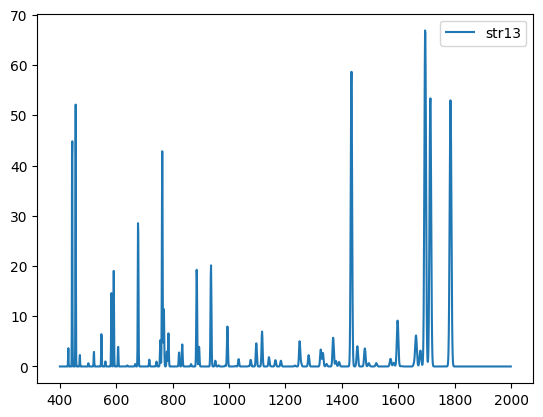

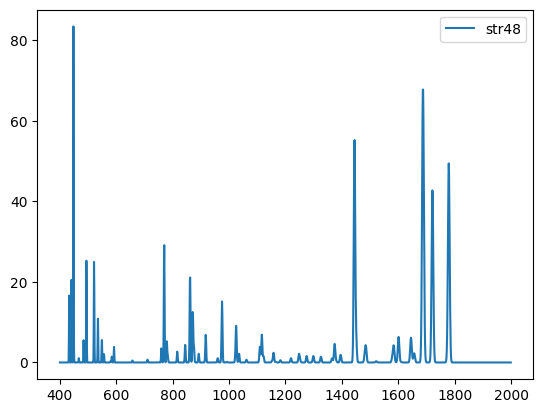

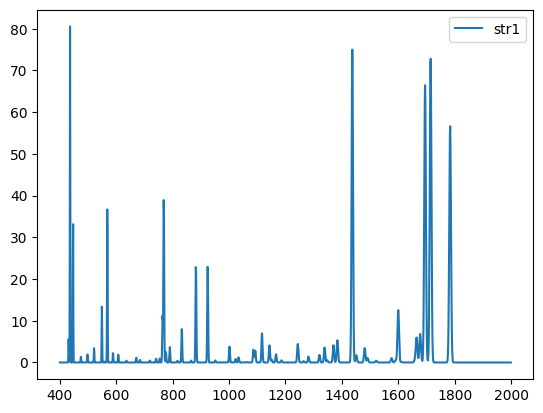

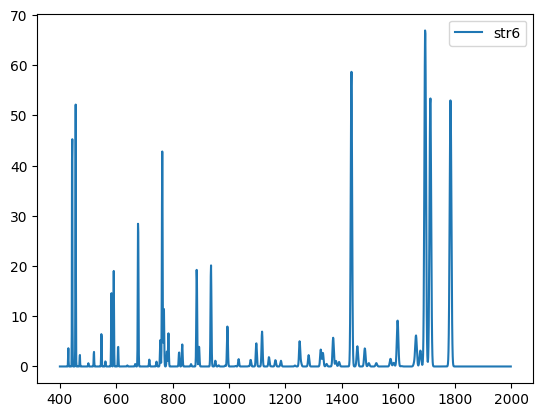

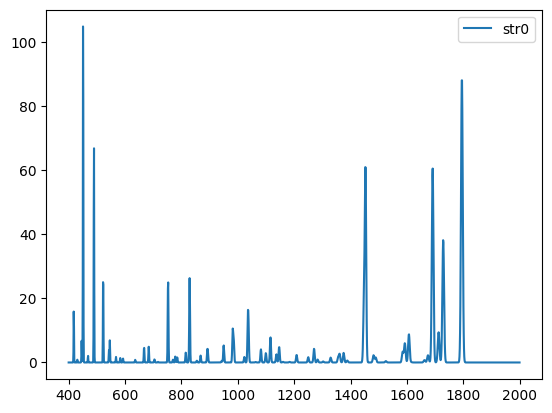

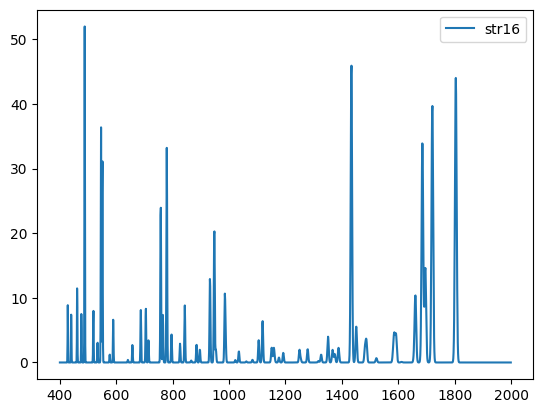

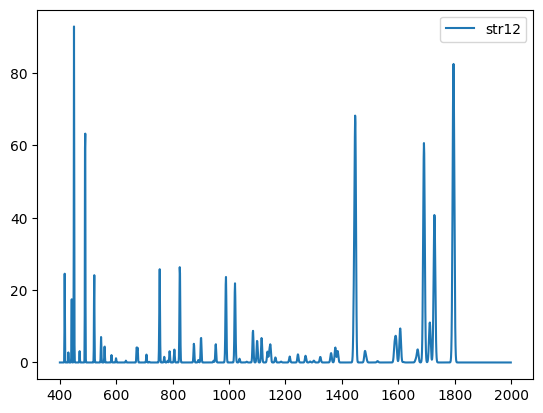

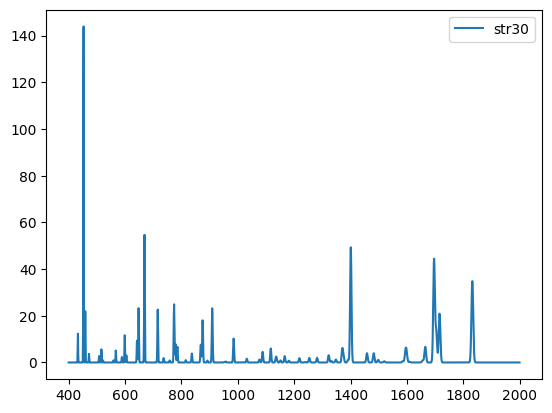

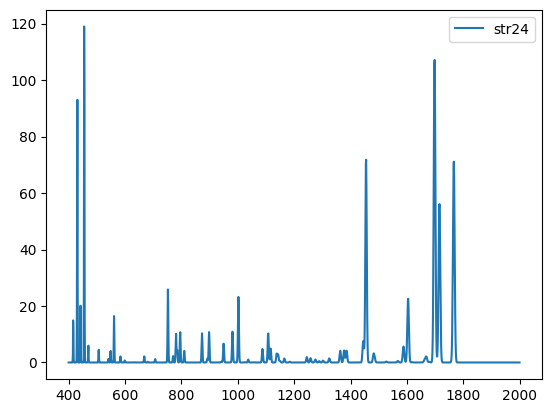

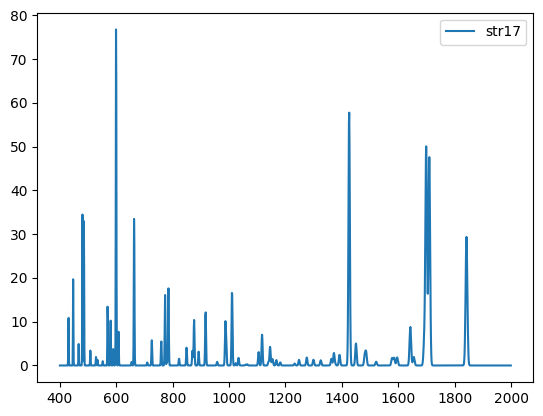

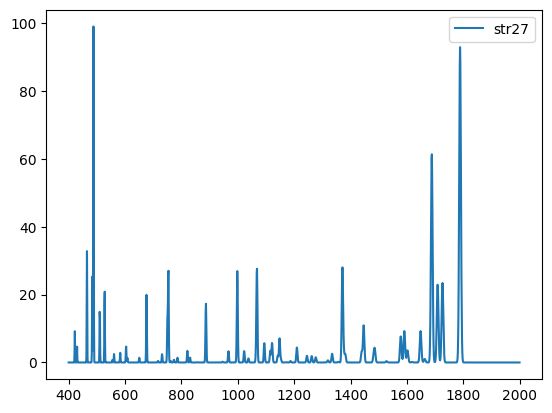

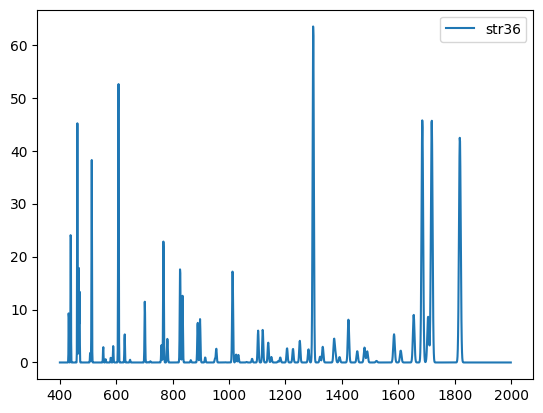

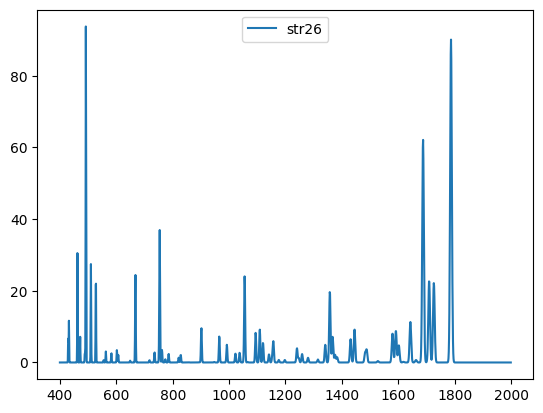

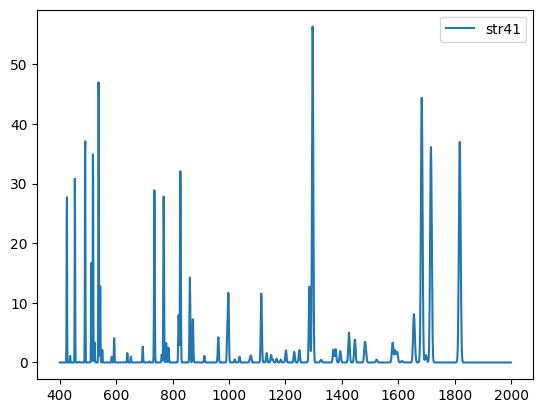

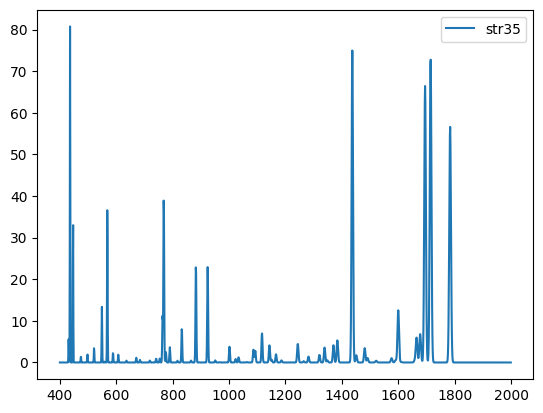

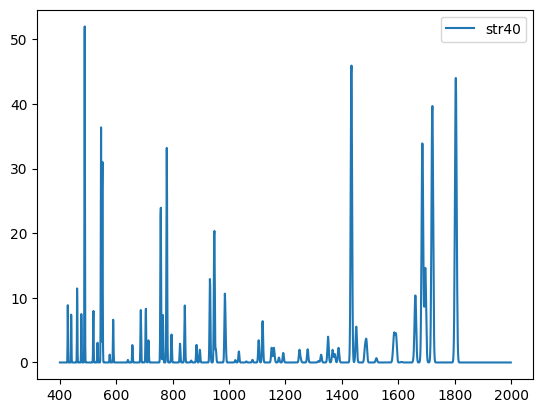

In [198]:
# When reading an file with just x-y data, the following would be enough:
# trans = np.loadtxt(input_file, skiprows=0)

# Parameter definition for plotting
#data_path = '/home/martint/Desktop/FHI/Projects/Guanidinium-AminoAcids/Gdm-His/Theory/non-zwitterion/'
#input_file = 'deprotPhosDimer_str3_b3lyp-augccpvtz-opttight-freq.log'
#output_file = 'IR_spectrum.dat'
# min and max wn, width of the gaussian, scaling factor
xmin = 0
xmax = 4000
width = 0.4 / 100.0 # 0.4% as the FEL
scale = 1.0

# Loop over freq files and generate IR spectra
for i, structure in enumerate(freq_files):
    # Create an empty 2D array with x from 0-4000 and y = 0
    IRspec = np.linspace((0,0), (4000,0), 4001)

    # Extract frequencies from g16 output file
    trans = extracting_freq(structure)
    for itrans in trans:
        sigma = width * itrans[0]/2.355
        IRspec[:,1] = IRspec[:,1] + itrans[1] * gaussian_fit(IRspec[:,0], itrans[0], sigma)

    # Print the theoretical spectrum
    IRspec = IRspec[400:2000,:2]
    #IRspec = IRspec[xmin:xmax,:2]
    sns.reset_defaults()
    np.savetxt(data_path + '/' + os.path.basename(structure).split(".log")[0]+"_ir.dat", IRspec) # output filename
    np.set_printoptions(threshold=np.inf)
    plt.plot(IRspec[:,0], IRspec[:,1], label=str_num[i])
    plt.legend()
#    plt.savefig(output_file.split(".log")[0]+"_ir.png")
    plt.show()
    